#Face Generation using Generative Adversarial Networks

The main idea behind a Generative Adversarial Network is the simultaneous training of a `Generator` and `Discriminator`

The `Generator` tries to learn a model to replicate the data (in this case the images) in such a way that they look like they come from the same distribution as the data

The `Discriminator` has to learn a model to detect whether an input image is real (from the dataset) or fake (made by the generator)

The initial GAN design (also called the Vanilla GAN now) uses only linear layers in the network

An improvement on this called DCGAN (Deep Convolutional GAN) uses Convolutional layers to learn a better Generator and Discriminator for images

Let's create a Vanilla GAN to start with

In [1]:
import torch
import torchvision
from torch import nn
import math

In [2]:
torch.__version__, torchvision.__version__

('2.3.0+cu121', '0.18.0+cu121')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

From the original paper by Ian Goodfellow et al:

"The generator nets used a mixture of rectifier linear activations [19,
9] and sigmoid activations, while the discriminator net used maxout [10] activations. Dropout [17]
was applied in training the discriminator net. While our theoretical framework permits the use of
dropout and other noise at intermediate layers of the generator, we used noise as the input to only
the bottommost layer of the generator network."

Both ReLU or LeakyReLU can be used in the intermediate layers but the output shape should be in range [-1, 1] (tanh) or [0, 1] (sigmoid) for ease of training.
Since training tanh is faster that is a good initial choice. Experimenting with sigmoid can be also be tested later.

In [4]:
class VanillaGenerator(nn.Module):
  def __init__(self,
               input_shape: int = 100,
               negative_slope: float = 0.2,  # 0.01 to 0.2 is a good range with 0.01 being closest to ReLU and 0.2 be far enough
               channels: int = 1,
               output_shape: int = 784):
    super().__init__()

    self.img_size = int(math.sqrt(output_shape / channels))
    self.channels = channels

    self.linear1 = nn.Sequential(
        nn.Linear(in_features = input_shape,
                  out_features = 256),
        nn.LeakyReLU(negative_slope)
    )

    self.linear2 = nn.Sequential(
        nn.Linear(in_features = 256,
                  out_features = 512),
        nn.LeakyReLU(negative_slope)
    )

    self.linear3 = nn.Sequential(
        nn.Linear(in_features = 512,
                  out_features = 1024),
        nn.LeakyReLU(negative_slope)
    )

    self.linear4 = nn.Sequential(
        nn.Linear(in_features = 1024,
                  out_features = output_shape),
        nn.Tanh()
    )

  def forward(self, x: torch.Tensor):
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x.view(-1, self.channels, self.img_size, self.img_size)  # (batch_size, channels, height, width); -1 for keeping same batch_size, 1 channel (greyscale) is assumed, img_size is image size

vanillaGenerator = VanillaGenerator()
vanillaGenerator

VanillaGenerator(
  (linear1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (linear4): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

The Discriminator slowly reduces the shape by going down to 1 (probability whether it is from original data)

The original paper suggests using Dropout in between the layers so that will be added

Also the final activation will be sigmoid since it is supposed to be a probability in range [0, 1]

In [5]:
class VanillaDiscriminator(nn.Module):
  def __init__(self,
               input_shape: int = 784,
               negative_slope: float = 0.2,
               dropout: float = 0.3,  # Commonly used dropout, can be changed
               channels: int = 1,
               output_shape: int = 1):
    super().__init__()

    self.input_shape = input_shape
    self.channels = channels

    self.linear1 = nn.Sequential(
        nn.Linear(in_features = input_shape,
                  out_features = 1024),
        nn.LeakyReLU(negative_slope),
        nn.Dropout(dropout)
    )

    self.linear2 = nn.Sequential(
        nn.Linear(in_features = 1024,
                  out_features = 512),
        nn.LeakyReLU(negative_slope),
        nn.Dropout(dropout)
    )

    self.linear3 = nn.Sequential(
        nn.Linear(in_features = 512,
                  out_features = 256),
        nn.LeakyReLU(negative_slope),
        nn.Dropout(dropout)
    )

    self.linear4 = nn.Sequential(
        nn.Linear(in_features = 256,
                  out_features = output_shape),
        nn.Sigmoid()
    )

  def forward(self, x: torch.Tensor):
    x = x.view(-1, self.input_shape)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

vanillaDiscriminator = VanillaDiscriminator().to(device)
vanillaDiscriminator

VanillaDiscriminator(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

##Setup some data to test if the Generator and Discriminator work separately

Let's start with MNIST since that was what was used by the paper

In [6]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

mnist_transform = transforms.Compose(
    [
        ToTensor(),
        transforms.Normalize(0.5, 0.5)  # To get the images in [-1, 1]
    ]
)

train_data = datasets.MNIST(
    root = "data/mnist",
    train = True,
    transform = mnist_transform,
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16172618.79it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 480907.12it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3784573.30it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9809747.05it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [7]:
print(len(train_data))

60000


tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

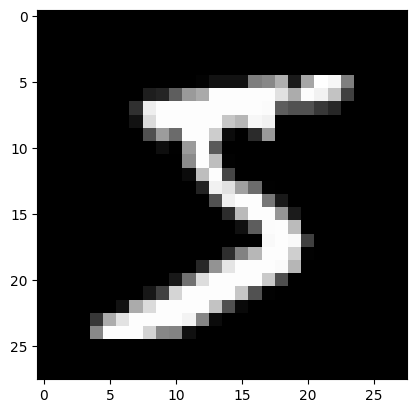

In [8]:
image, label = train_data[0]
print(image, label)
plt.imshow(image.squeeze(),
           cmap="gray")

Setting up the dataloader

In [9]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = batch_size,
                              shuffle = True,
                              drop_last=True)

In [10]:
len(train_dataloader)

937

Text(0.5, 1.0, '3')

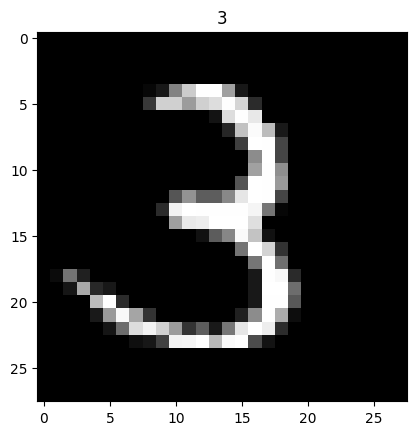

In [11]:
images, labels = next(iter(train_dataloader))

test_image, label = images[0], labels[0].item()

plt.imshow(test_image.squeeze(0),
           cmap = "gray")
plt.title(label)

Testing with the Discriminator

In [12]:
disc_output = vanillaDiscriminator(test_image.to(device))
disc_output

tensor([[0.4961]], device='cuda:0', grad_fn=<SigmoidBackward0>)

The disciriminator seems to be working well so now let's test the Generator

The generator needs a random vector (100 dimensions is good for an image of 28x28)

The input noise shape: torch.Size([1, 100])
The output of the generator's shape: torch.Size([1, 1, 28, 28])


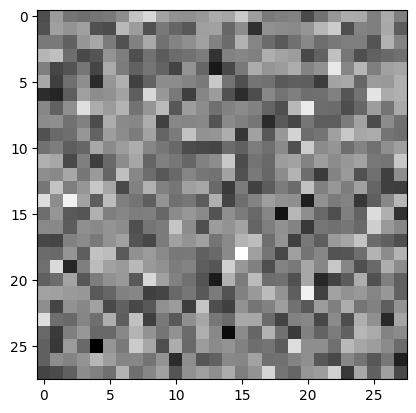

In [13]:
vanillaGenerator = VanillaGenerator().to(device)
vanillaDiscriminator = VanillaDiscriminator().to(device)

torch.manual_seed(42)

vanillaGenerator.eval()
noise = torch.randn(1, 100, device=device).to(device)
print(f"The input noise shape: {noise.shape}")

gen_output = vanillaGenerator(noise)
print(f"The output of the generator's shape: {gen_output.shape}")

# Squeeze to remove batch_size
plt.imshow(gen_output.cpu().detach().squeeze(),
           cmap = "gray")

That is quite random but that only shows that the generator is working as intended

##Training the GAN

Now, we start with setting up the training loop for the GAN

The way to train the Discriminator is to give it both real images and generated images with the correct label (1 for real, 0 for fake)
As for the Generator, its goal is to *maximize* the BCELoss of the discriminator with its generated images.
But maximizing this loss can be viewed in another perspective that will better fit how PyTorch does things.
We can normally go ahead and feed the Generated images to the Discriminator, but we will use the predicted probabilities from this to find the BCELoss for the generator with the ground truth values being *all ones*. This trick makes it so that the output of the generator is treated as *good* when the discriminator thinks it is real and *bad* otherwise.

In [ ]:
from tqdm.auto import tqdm

def train_gan(loss_fn: nn.Module,
              train_dataloader,
              device,
              channels: int = 1,
              img_size: int = 784,
              noise_len: int = 100,
              batch_size: int = 64,
              k: int = 1,  # Taking k as 1 is the least compute expensive
              epochs: int = 50,
              type: str = "vanilla",):

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    if type == "vanilla":
        discriminator = VanillaDiscriminator(channels = channels, input_shape = img_size).to(device)
        generator = VanillaGenerator(input_shape = noise_len, output_shape = img_size, channels = channels).to(device)

        disc_optimizer = torch.optim.Adam(discriminator.parameters(),
                                          lr = 0.0002,
                                          betas = (0.5, 0.999))
        gen_optimizer = torch.optim.Adam(generator.parameters(),
                                         lr = 0.0002,
                                         betas = (0.5, 0.999))

    if not discriminator or not generator:
        raise Exception("discriminator or generator unbounded")

    for epoch in tqdm(range(epochs)):

        for ind, (X, _) in enumerate(train_dataloader):

            discriminator.train()
            generator.train()

            X = X.to(device)
            # Take disc loss with real images
            disc_output = discriminator(X)
            disc_real_loss = loss_fn(disc_output, real_labels)

            # Generate fake images and take disc loss
            noise = torch.randn(batch_size, noise_len).to(device)
            disc_output = discriminator(generator(noise))

            disc_fake_loss = loss_fn(disc_output, fake_labels)

            disc_loss = disc_real_loss + disc_fake_loss

            if ind % 250 == 0:
                print(f"Epoch: {epoch} Step: {ind}, discriminant loss: {disc_loss}")

            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()

            if ind % k == 0:
                noise = torch.randn(batch_size, noise_len).to(device)
                disc_output = discriminator(generator(noise))
                gen_loss = loss_fn(disc_output, real_labels)

                if ind % 250 == 0:
                    print(f"Epoch: {epoch}, Step: {ind}, generator loss: {gen_loss}")

                gen_optimizer.zero_grad()
                gen_loss.backward()
                gen_optimizer.step()

        generator.eval()
        gen_image = generator(torch.randn(1, 100).to(device)).cpu().detach().squeeze().permute(1,2,0)
        plt.imshow(gen_image, cmap="gray")
        plt.show()

    return generator, discriminator


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Step: 0, discriminant loss: 1.376244306564331

Epoch: 0, Step: 0, generator loss: 0.7080545425415039

Epoch: 0 Step: 250, discriminant loss: 0.47887375950813293

Epoch: 0, Step: 250, generator loss: 2.065384864807129

Epoch: 0 Step: 500, discriminant loss: 0.969508945941925

Epoch: 0, Step: 500, generator loss: 4.638021469116211

Epoch: 0 Step: 750, discriminant loss: 0.49217987060546875

Epoch: 0, Step: 750, generator loss: 1.7406599521636963


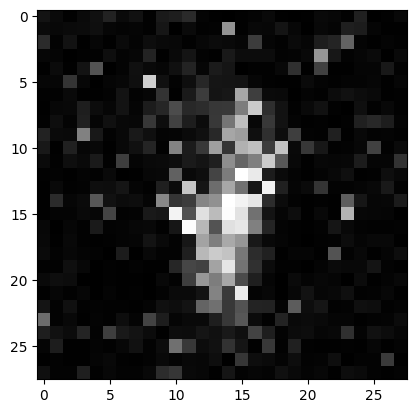

  2%|▏         | 1/50 [00:24<20:08, 24.67s/it]

Epoch: 1 Step: 0, discriminant loss: 0.3393864929676056

Epoch: 1, Step: 0, generator loss: 2.853579521179199

Epoch: 1 Step: 250, discriminant loss: 0.469510555267334

Epoch: 1, Step: 250, generator loss: 2.3215627670288086

Epoch: 1 Step: 500, discriminant loss: 0.400454044342041

Epoch: 1, Step: 500, generator loss: 2.964442253112793

Epoch: 1 Step: 750, discriminant loss: 0.4114968776702881

Epoch: 1, Step: 750, generator loss: 2.5966835021972656


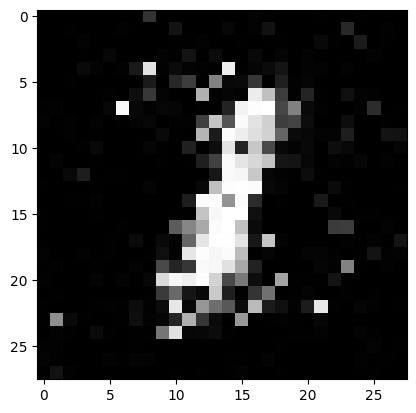

  4%|▍         | 2/50 [00:48<19:29, 24.37s/it]

Epoch: 2 Step: 0, discriminant loss: 0.8327463269233704

Epoch: 2, Step: 0, generator loss: 1.3847103118896484

Epoch: 2 Step: 250, discriminant loss: 0.2616588771343231

Epoch: 2, Step: 250, generator loss: 2.986894130706787

Epoch: 2 Step: 500, discriminant loss: 0.19921188056468964

Epoch: 2, Step: 500, generator loss: 3.4152560234069824

Epoch: 2 Step: 750, discriminant loss: 0.1383562535047531

Epoch: 2, Step: 750, generator loss: 3.8839192390441895


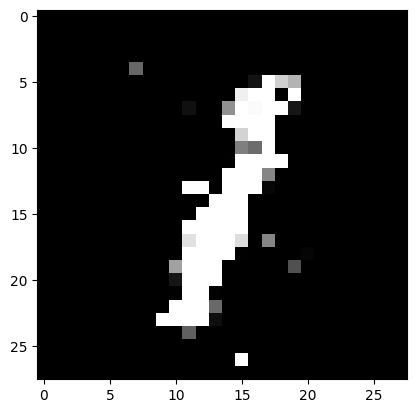

  6%|▌         | 3/50 [01:12<18:49, 24.03s/it]

Epoch: 3 Step: 0, discriminant loss: 0.41518035531044006

Epoch: 3, Step: 0, generator loss: 2.394399404525757

Epoch: 3 Step: 250, discriminant loss: 0.3789394497871399

Epoch: 3, Step: 250, generator loss: 2.329411029815674

Epoch: 3 Step: 500, discriminant loss: 0.6113680601119995

Epoch: 3, Step: 500, generator loss: 3.7829203605651855

Epoch: 3 Step: 750, discriminant loss: 0.5847035646438599

Epoch: 3, Step: 750, generator loss: 1.3721339702606201


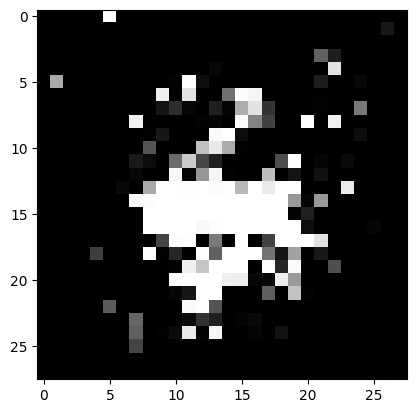

  8%|▊         | 4/50 [01:35<18:02, 23.53s/it]

Epoch: 4 Step: 0, discriminant loss: 0.6052051186561584

Epoch: 4, Step: 0, generator loss: 2.0879077911376953

Epoch: 4 Step: 250, discriminant loss: 0.3897653818130493

Epoch: 4, Step: 250, generator loss: 1.737327218055725

Epoch: 4 Step: 500, discriminant loss: 0.6355671882629395

Epoch: 4, Step: 500, generator loss: 2.084031820297241

Epoch: 4 Step: 750, discriminant loss: 0.8495146036148071

Epoch: 4, Step: 750, generator loss: 1.5644277334213257


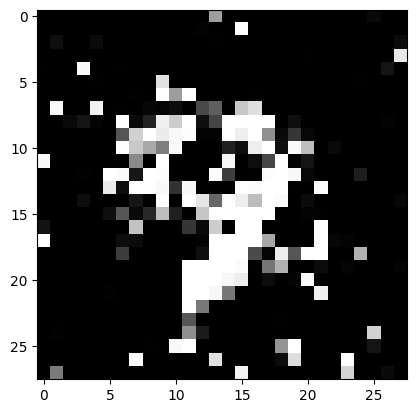

 10%|█         | 5/50 [01:57<17:19, 23.11s/it]

Epoch: 5 Step: 0, discriminant loss: 0.5953641533851624

Epoch: 5, Step: 0, generator loss: 3.30397367477417

Epoch: 5 Step: 250, discriminant loss: 0.9433578252792358

Epoch: 5, Step: 250, generator loss: 2.0221564769744873

Epoch: 5 Step: 500, discriminant loss: 0.7304664254188538

Epoch: 5, Step: 500, generator loss: 1.539747714996338

Epoch: 5 Step: 750, discriminant loss: 0.731728732585907

Epoch: 5, Step: 750, generator loss: 2.1740074157714844


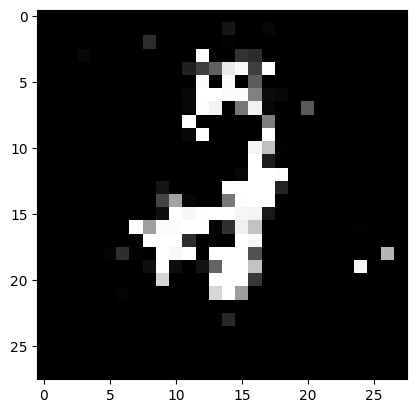

 12%|█▏        | 6/50 [02:19<16:43, 22.81s/it]

Epoch: 6 Step: 0, discriminant loss: 0.7313395738601685

Epoch: 6, Step: 0, generator loss: 1.8504626750946045

Epoch: 6 Step: 250, discriminant loss: 0.7888321876525879

Epoch: 6, Step: 250, generator loss: 1.8153884410858154

Epoch: 6 Step: 500, discriminant loss: 1.5009806156158447

Epoch: 6, Step: 500, generator loss: 1.008764624595642

Epoch: 6 Step: 750, discriminant loss: 0.7871074080467224

Epoch: 6, Step: 750, generator loss: 1.2943565845489502


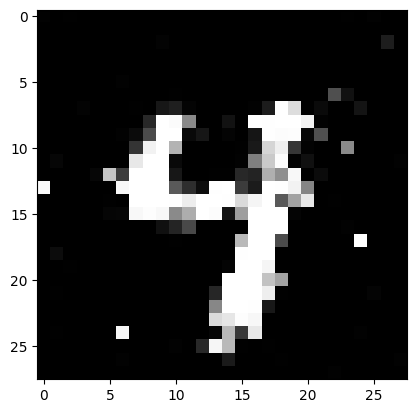

 14%|█▍        | 7/50 [02:42<16:13, 22.64s/it]

Epoch: 7 Step: 0, discriminant loss: 1.1130129098892212

Epoch: 7, Step: 0, generator loss: 2.2077536582946777

Epoch: 7 Step: 250, discriminant loss: 0.8031839728355408

Epoch: 7, Step: 250, generator loss: 1.6846266984939575

Epoch: 7 Step: 500, discriminant loss: 0.8460688591003418

Epoch: 7, Step: 500, generator loss: 1.434053897857666

Epoch: 7 Step: 750, discriminant loss: 0.9475272297859192

Epoch: 7, Step: 750, generator loss: 1.3463399410247803


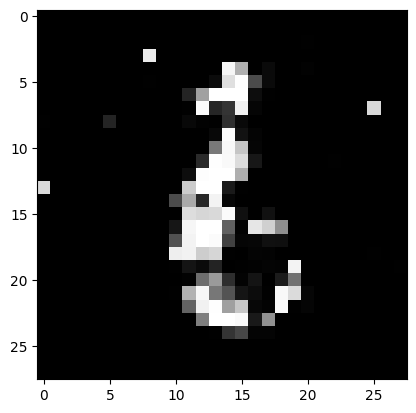

 16%|█▌        | 8/50 [03:04<15:49, 22.60s/it]

Epoch: 8 Step: 0, discriminant loss: 0.9619567394256592

Epoch: 8, Step: 0, generator loss: 1.1435329914093018

Epoch: 8 Step: 250, discriminant loss: 0.9705825448036194

Epoch: 8, Step: 250, generator loss: 1.131417989730835

Epoch: 8 Step: 500, discriminant loss: 1.0382617712020874

Epoch: 8, Step: 500, generator loss: 1.4214038848876953

Epoch: 8 Step: 750, discriminant loss: 0.9826948642730713

Epoch: 8, Step: 750, generator loss: 1.3140593767166138


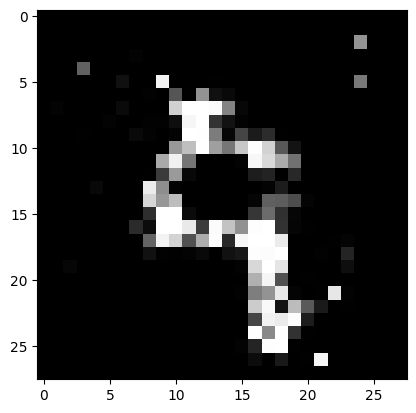

 18%|█▊        | 9/50 [03:27<15:31, 22.71s/it]

Epoch: 9 Step: 0, discriminant loss: 1.1194665431976318

Epoch: 9, Step: 0, generator loss: 1.093778133392334

Epoch: 9 Step: 250, discriminant loss: 0.9612153172492981

Epoch: 9, Step: 250, generator loss: 1.2948452234268188

Epoch: 9 Step: 500, discriminant loss: 1.0702905654907227

Epoch: 9, Step: 500, generator loss: 1.146787405014038

Epoch: 9 Step: 750, discriminant loss: 1.0529770851135254

Epoch: 9, Step: 750, generator loss: 1.489471197128296


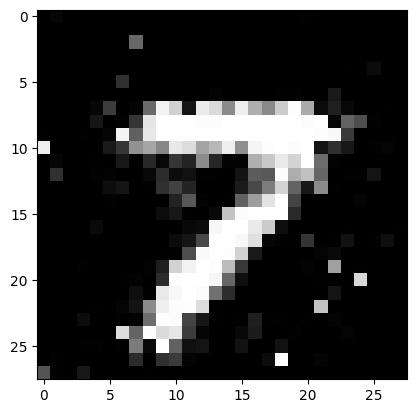

 20%|██        | 10/50 [03:50<15:12, 22.81s/it]

Epoch: 10 Step: 0, discriminant loss: 1.0495104789733887

Epoch: 10, Step: 0, generator loss: 1.1799871921539307

Epoch: 10 Step: 250, discriminant loss: 1.0384613275527954

Epoch: 10, Step: 250, generator loss: 1.5527267456054688

Epoch: 10 Step: 500, discriminant loss: 1.0412464141845703

Epoch: 10, Step: 500, generator loss: 1.0321717262268066

Epoch: 10 Step: 750, discriminant loss: 1.1480733156204224

Epoch: 10, Step: 750, generator loss: 1.4357430934906006


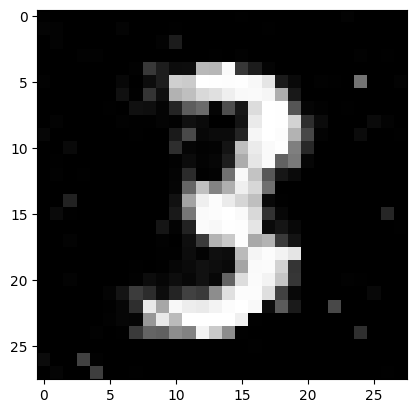

 22%|██▏       | 11/50 [04:13<14:48, 22.77s/it]

Epoch: 11 Step: 0, discriminant loss: 1.130852460861206

Epoch: 11, Step: 0, generator loss: 0.9914332032203674

Epoch: 11 Step: 250, discriminant loss: 1.0622591972351074

Epoch: 11, Step: 250, generator loss: 1.0311139822006226

Epoch: 11 Step: 500, discriminant loss: 1.2182228565216064

Epoch: 11, Step: 500, generator loss: 1.1360008716583252

Epoch: 11 Step: 750, discriminant loss: 1.1440987586975098

Epoch: 11, Step: 750, generator loss: 1.1337682008743286


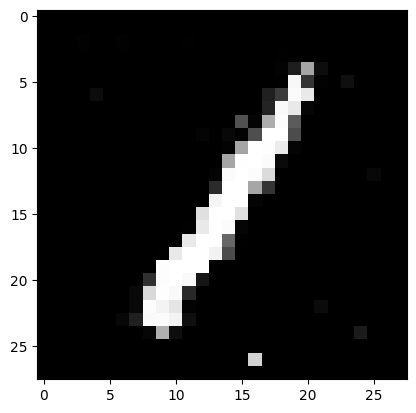

 24%|██▍       | 12/50 [04:35<14:23, 22.73s/it]

Epoch: 12 Step: 0, discriminant loss: 1.1308280229568481

Epoch: 12, Step: 0, generator loss: 0.8802750110626221

Epoch: 12 Step: 250, discriminant loss: 1.1677250862121582

Epoch: 12, Step: 250, generator loss: 1.2008554935455322

Epoch: 12 Step: 500, discriminant loss: 1.0743577480316162

Epoch: 12, Step: 500, generator loss: 1.046882152557373

Epoch: 12 Step: 750, discriminant loss: 1.1376736164093018

Epoch: 12, Step: 750, generator loss: 1.0552538633346558


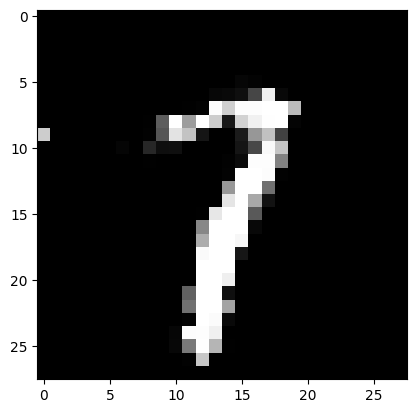

 26%|██▌       | 13/50 [04:59<14:07, 22.91s/it]

Epoch: 13 Step: 0, discriminant loss: 1.1510504484176636

Epoch: 13, Step: 0, generator loss: 1.5384304523468018

Epoch: 13 Step: 250, discriminant loss: 1.2252330780029297

Epoch: 13, Step: 250, generator loss: 1.2625935077667236

Epoch: 13 Step: 500, discriminant loss: 1.1849738359451294

Epoch: 13, Step: 500, generator loss: 1.083591103553772

Epoch: 13 Step: 750, discriminant loss: 1.1751928329467773

Epoch: 13, Step: 750, generator loss: 1.1394522190093994


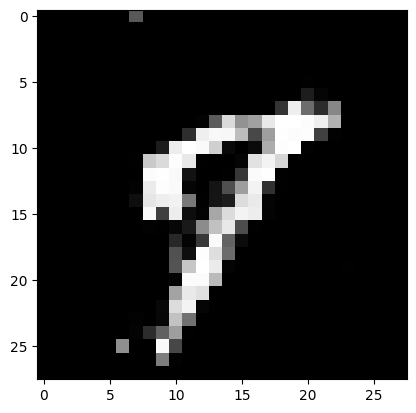

 28%|██▊       | 14/50 [05:21<13:41, 22.81s/it]

Epoch: 14 Step: 0, discriminant loss: 1.0420637130737305

Epoch: 14, Step: 0, generator loss: 0.9893093109130859

Epoch: 14 Step: 250, discriminant loss: 1.1452271938323975

Epoch: 14, Step: 250, generator loss: 1.0916236639022827

Epoch: 14 Step: 500, discriminant loss: 1.1769375801086426

Epoch: 14, Step: 500, generator loss: 0.8826907873153687

Epoch: 14 Step: 750, discriminant loss: 1.1229366064071655

Epoch: 14, Step: 750, generator loss: 0.9194977283477783


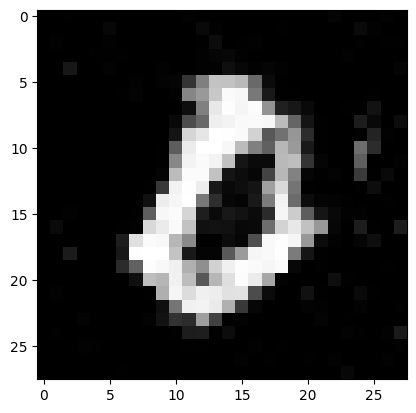

 30%|███       | 15/50 [05:44<13:11, 22.63s/it]

Epoch: 15 Step: 0, discriminant loss: 1.0128087997436523

Epoch: 15, Step: 0, generator loss: 0.9918732643127441

Epoch: 15 Step: 250, discriminant loss: 1.1162134408950806

Epoch: 15, Step: 250, generator loss: 1.0390346050262451

Epoch: 15 Step: 500, discriminant loss: 1.098356008529663

Epoch: 15, Step: 500, generator loss: 1.2098368406295776

Epoch: 15 Step: 750, discriminant loss: 1.1913682222366333

Epoch: 15, Step: 750, generator loss: 0.861041784286499


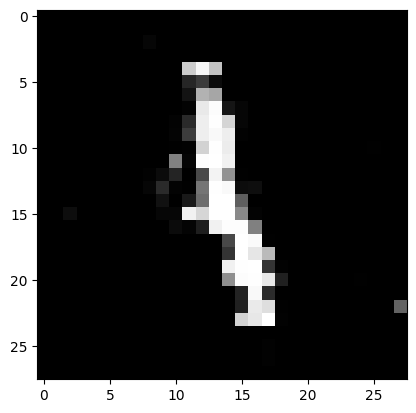

 32%|███▏      | 16/50 [06:07<12:52, 22.73s/it]

Epoch: 16 Step: 0, discriminant loss: 0.9939225316047668

Epoch: 16, Step: 0, generator loss: 1.024475336074829

Epoch: 16 Step: 250, discriminant loss: 0.991553783416748

Epoch: 16, Step: 250, generator loss: 1.2300989627838135

Epoch: 16 Step: 500, discriminant loss: 1.055486798286438

Epoch: 16, Step: 500, generator loss: 1.1290302276611328

Epoch: 16 Step: 750, discriminant loss: 1.0814189910888672

Epoch: 16, Step: 750, generator loss: 0.970402717590332


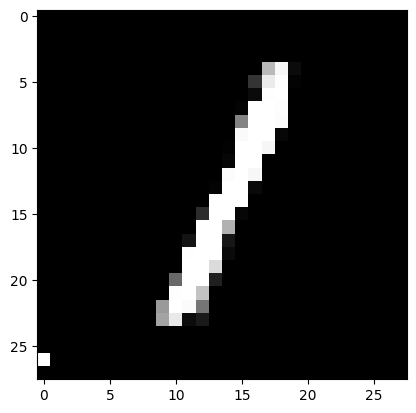

 34%|███▍      | 17/50 [06:30<12:41, 23.09s/it]

Epoch: 17 Step: 0, discriminant loss: 1.2022879123687744

Epoch: 17, Step: 0, generator loss: 0.9663077592849731

Epoch: 17 Step: 250, discriminant loss: 1.2395209074020386

Epoch: 17, Step: 250, generator loss: 1.1728935241699219

Epoch: 17 Step: 500, discriminant loss: 1.1970700025558472

Epoch: 17, Step: 500, generator loss: 0.8998054265975952

Epoch: 17 Step: 750, discriminant loss: 1.239678978919983

Epoch: 17, Step: 750, generator loss: 0.8910747766494751


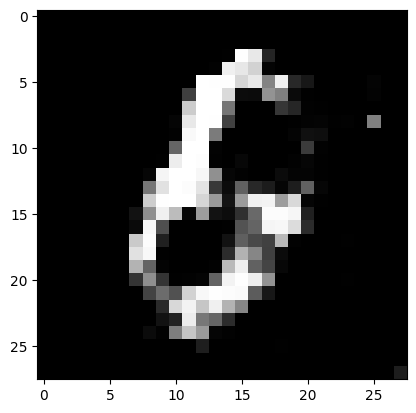

 36%|███▌      | 18/50 [06:54<12:25, 23.31s/it]

Epoch: 18 Step: 0, discriminant loss: 1.123633623123169

Epoch: 18, Step: 0, generator loss: 0.9272235631942749

Epoch: 18 Step: 250, discriminant loss: 1.1273159980773926

Epoch: 18, Step: 250, generator loss: 0.9358929991722107

Epoch: 18 Step: 500, discriminant loss: 1.1563271284103394

Epoch: 18, Step: 500, generator loss: 1.1422983407974243

Epoch: 18 Step: 750, discriminant loss: 1.203445553779602

Epoch: 18, Step: 750, generator loss: 0.8901337385177612


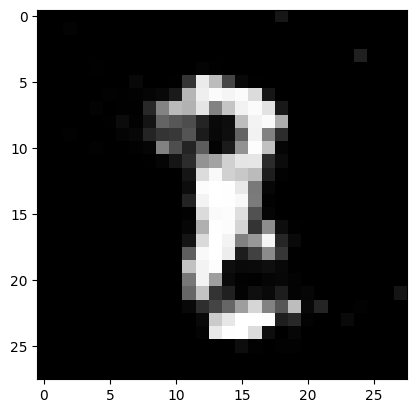

 38%|███▊      | 19/50 [07:17<12:00, 23.23s/it]

Epoch: 19 Step: 0, discriminant loss: 1.2367089986801147

Epoch: 19, Step: 0, generator loss: 1.0166760683059692

Epoch: 19 Step: 250, discriminant loss: 1.2516379356384277

Epoch: 19, Step: 250, generator loss: 1.0810667276382446

Epoch: 19 Step: 500, discriminant loss: 1.1510956287384033

Epoch: 19, Step: 500, generator loss: 1.1034870147705078

Epoch: 19 Step: 750, discriminant loss: 1.117654800415039

Epoch: 19, Step: 750, generator loss: 0.939217209815979


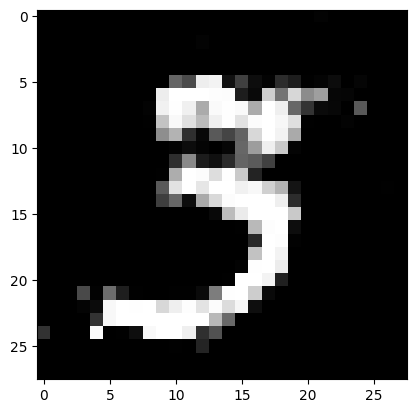

 40%|████      | 20/50 [07:40<11:36, 23.22s/it]

Epoch: 20 Step: 0, discriminant loss: 1.1087379455566406

Epoch: 20, Step: 0, generator loss: 1.1768066883087158

Epoch: 20 Step: 250, discriminant loss: 1.1753768920898438

Epoch: 20, Step: 250, generator loss: 1.0265522003173828

Epoch: 20 Step: 500, discriminant loss: 1.2043073177337646

Epoch: 20, Step: 500, generator loss: 0.888559103012085

Epoch: 20 Step: 750, discriminant loss: 1.0977246761322021

Epoch: 20, Step: 750, generator loss: 1.0782685279846191


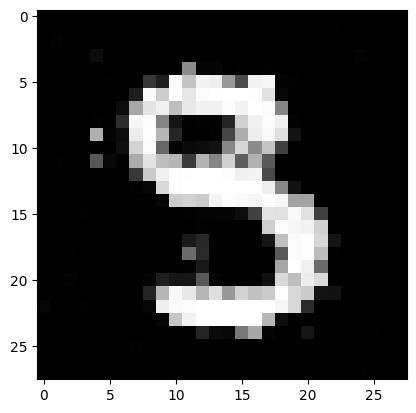

 42%|████▏     | 21/50 [08:05<11:23, 23.56s/it]

Epoch: 21 Step: 0, discriminant loss: 1.1444334983825684

Epoch: 21, Step: 0, generator loss: 0.8935586214065552

Epoch: 21 Step: 250, discriminant loss: 1.2087572813034058

Epoch: 21, Step: 250, generator loss: 1.0799481868743896

Epoch: 21 Step: 500, discriminant loss: 1.103771448135376

Epoch: 21, Step: 500, generator loss: 1.0094321966171265

Epoch: 21 Step: 750, discriminant loss: 1.3274102210998535

Epoch: 21, Step: 750, generator loss: 1.0399565696716309


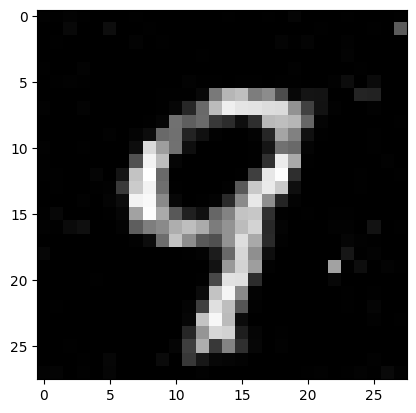

 44%|████▍     | 22/50 [08:29<11:00, 23.60s/it]

Epoch: 22 Step: 0, discriminant loss: 1.2968416213989258

Epoch: 22, Step: 0, generator loss: 1.091080904006958

Epoch: 22 Step: 250, discriminant loss: 1.195565938949585

Epoch: 22, Step: 250, generator loss: 0.9162073731422424

Epoch: 22 Step: 500, discriminant loss: 1.183022379875183

Epoch: 22, Step: 500, generator loss: 1.106446623802185

Epoch: 22 Step: 750, discriminant loss: 1.0777934789657593

Epoch: 22, Step: 750, generator loss: 1.104600429534912


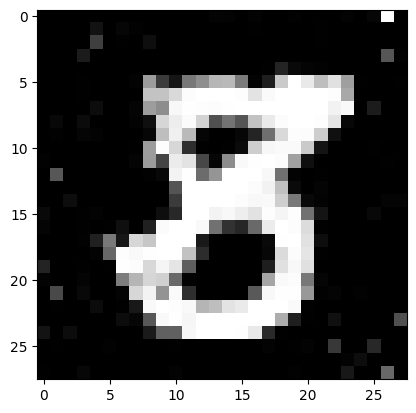

 46%|████▌     | 23/50 [08:52<10:38, 23.65s/it]

Epoch: 23 Step: 0, discriminant loss: 1.3889662027359009

Epoch: 23, Step: 0, generator loss: 0.8852792978286743

Epoch: 23 Step: 250, discriminant loss: 1.3404030799865723

Epoch: 23, Step: 250, generator loss: 1.001362919807434

Epoch: 23 Step: 500, discriminant loss: 1.1319336891174316

Epoch: 23, Step: 500, generator loss: 1.0237661600112915

Epoch: 23 Step: 750, discriminant loss: 1.1854987144470215

Epoch: 23, Step: 750, generator loss: 1.0806161165237427


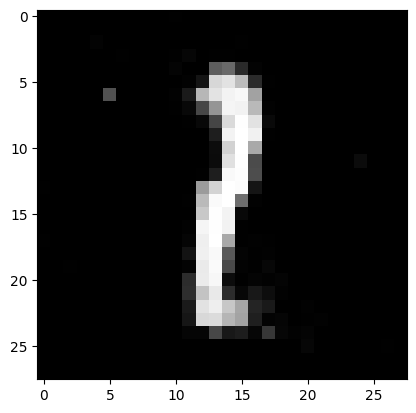

 48%|████▊     | 24/50 [09:15<10:09, 23.43s/it]

Epoch: 24 Step: 0, discriminant loss: 1.179211974143982

Epoch: 24, Step: 0, generator loss: 1.1217331886291504

Epoch: 24 Step: 250, discriminant loss: 1.173490047454834

Epoch: 24, Step: 250, generator loss: 0.9848995208740234

Epoch: 24 Step: 500, discriminant loss: 1.128292202949524

Epoch: 24, Step: 500, generator loss: 0.9442356824874878

Epoch: 24 Step: 750, discriminant loss: 1.1941006183624268

Epoch: 24, Step: 750, generator loss: 0.9568803906440735


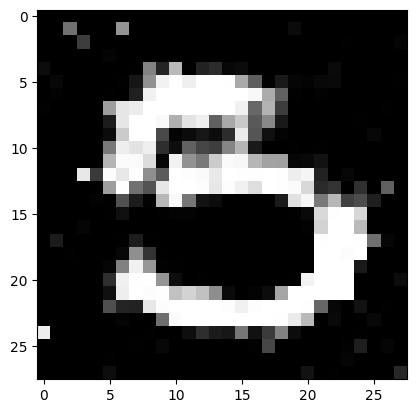

 50%|█████     | 25/50 [09:39<09:44, 23.40s/it]

Epoch: 25 Step: 0, discriminant loss: 1.1179656982421875

Epoch: 25, Step: 0, generator loss: 1.1239855289459229

Epoch: 25 Step: 250, discriminant loss: 1.2775866985321045

Epoch: 25, Step: 250, generator loss: 1.124514102935791

Epoch: 25 Step: 500, discriminant loss: 1.1759016513824463

Epoch: 25, Step: 500, generator loss: 1.0410312414169312

Epoch: 25 Step: 750, discriminant loss: 1.2479183673858643

Epoch: 25, Step: 750, generator loss: 0.8962616324424744


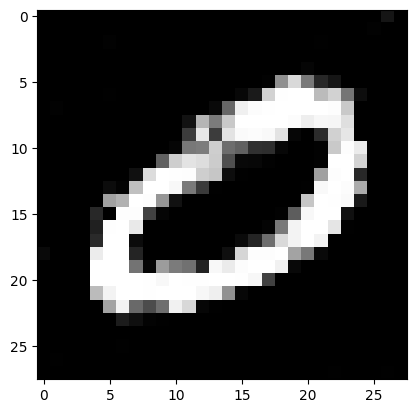

 52%|█████▏    | 26/50 [10:02<09:23, 23.48s/it]

Epoch: 26 Step: 0, discriminant loss: 1.2094608545303345

Epoch: 26, Step: 0, generator loss: 1.1306917667388916

Epoch: 26 Step: 250, discriminant loss: 1.1382837295532227

Epoch: 26, Step: 250, generator loss: 1.2107480764389038

Epoch: 26 Step: 500, discriminant loss: 1.224144458770752

Epoch: 26, Step: 500, generator loss: 1.026920199394226

Epoch: 26 Step: 750, discriminant loss: 1.0906310081481934

Epoch: 26, Step: 750, generator loss: 0.8864009380340576


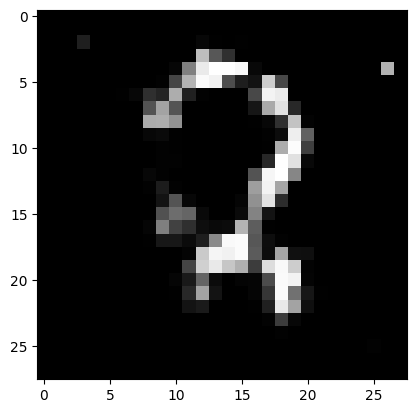

 54%|█████▍    | 27/50 [10:27<09:06, 23.75s/it]

Epoch: 27 Step: 0, discriminant loss: 1.1013367176055908

Epoch: 27, Step: 0, generator loss: 1.1766395568847656

Epoch: 27 Step: 250, discriminant loss: 1.0825716257095337

Epoch: 27, Step: 250, generator loss: 0.9503829479217529

Epoch: 27 Step: 500, discriminant loss: 1.275538444519043

Epoch: 27, Step: 500, generator loss: 0.8875358700752258

Epoch: 27 Step: 750, discriminant loss: 1.071274757385254

Epoch: 27, Step: 750, generator loss: 1.047694444656372


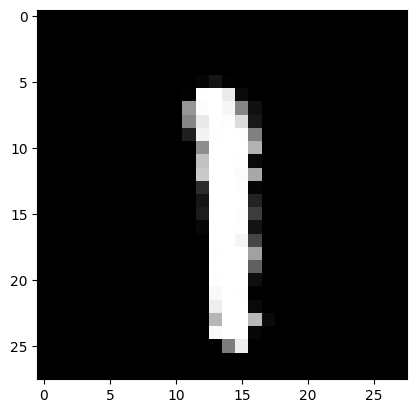

 56%|█████▌    | 28/50 [10:52<08:55, 24.36s/it]

Epoch: 28 Step: 0, discriminant loss: 1.230189323425293

Epoch: 28, Step: 0, generator loss: 1.1983860731124878

Epoch: 28 Step: 250, discriminant loss: 1.11279296875

Epoch: 28, Step: 250, generator loss: 1.1261839866638184

Epoch: 28 Step: 500, discriminant loss: 1.129165530204773

Epoch: 28, Step: 500, generator loss: 1.090491771697998

Epoch: 28 Step: 750, discriminant loss: 1.3155895471572876

Epoch: 28, Step: 750, generator loss: 1.0506694316864014


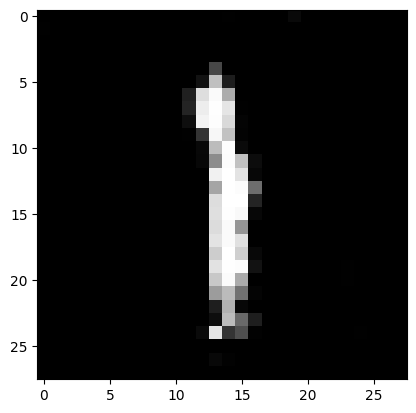

 58%|█████▊    | 29/50 [11:18<08:39, 24.73s/it]

Epoch: 29 Step: 0, discriminant loss: 1.149772047996521

Epoch: 29, Step: 0, generator loss: 0.9290387630462646

Epoch: 29 Step: 250, discriminant loss: 1.148014783859253

Epoch: 29, Step: 250, generator loss: 0.9707828164100647

Epoch: 29 Step: 500, discriminant loss: 1.0570977926254272

Epoch: 29, Step: 500, generator loss: 0.9491270184516907

Epoch: 29 Step: 750, discriminant loss: 1.2021249532699585

Epoch: 29, Step: 750, generator loss: 0.8820441365242004


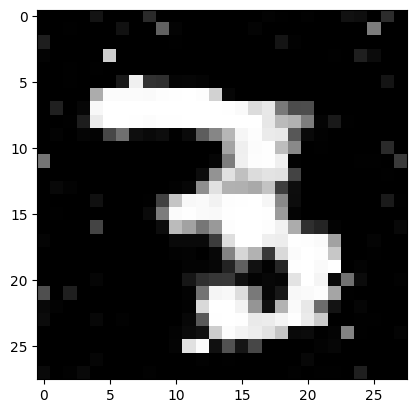

 60%|██████    | 30/50 [11:45<08:30, 25.52s/it]

Epoch: 30 Step: 0, discriminant loss: 1.1317152976989746

Epoch: 30, Step: 0, generator loss: 0.8944078683853149

Epoch: 30 Step: 250, discriminant loss: 1.1557234525680542

Epoch: 30, Step: 250, generator loss: 0.9860991835594177

Epoch: 30 Step: 500, discriminant loss: 1.2053587436676025

Epoch: 30, Step: 500, generator loss: 1.0274484157562256

Epoch: 30 Step: 750, discriminant loss: 1.2484130859375

Epoch: 30, Step: 750, generator loss: 1.0379502773284912


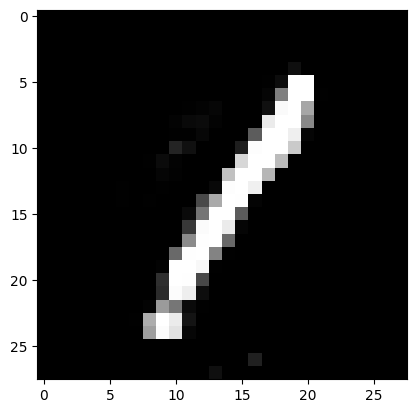

 62%|██████▏   | 31/50 [12:10<08:02, 25.41s/it]

Epoch: 31 Step: 0, discriminant loss: 1.230247974395752

Epoch: 31, Step: 0, generator loss: 1.1062376499176025

Epoch: 31 Step: 250, discriminant loss: 1.250158667564392

Epoch: 31, Step: 250, generator loss: 0.9123293161392212

Epoch: 31 Step: 500, discriminant loss: 1.1034812927246094

Epoch: 31, Step: 500, generator loss: 0.9663035273551941

Epoch: 31 Step: 750, discriminant loss: 1.2679815292358398

Epoch: 31, Step: 750, generator loss: 0.7973282337188721


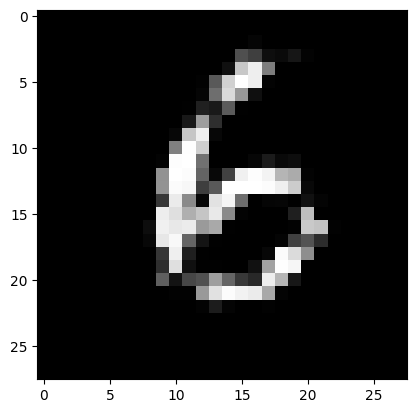

 64%|██████▍   | 32/50 [12:36<07:35, 25.30s/it]

Epoch: 32 Step: 0, discriminant loss: 1.2123782634735107

Epoch: 32, Step: 0, generator loss: 1.0917255878448486

Epoch: 32 Step: 250, discriminant loss: 1.174781084060669

Epoch: 32, Step: 250, generator loss: 0.8421872854232788

Epoch: 32 Step: 500, discriminant loss: 1.2325519323349

Epoch: 32, Step: 500, generator loss: 1.0047245025634766

Epoch: 32 Step: 750, discriminant loss: 1.0547709465026855

Epoch: 32, Step: 750, generator loss: 1.0769429206848145


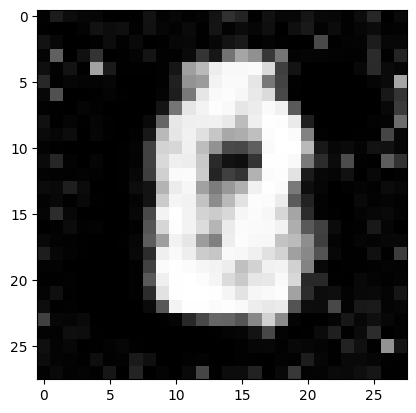

 66%|██████▌   | 33/50 [12:59<07:00, 24.76s/it]

Epoch: 33 Step: 0, discriminant loss: 1.2532875537872314

Epoch: 33, Step: 0, generator loss: 1.0261156558990479

Epoch: 33 Step: 250, discriminant loss: 1.3107532262802124

Epoch: 33, Step: 250, generator loss: 0.9253770709037781

Epoch: 33 Step: 500, discriminant loss: 1.2800564765930176

Epoch: 33, Step: 500, generator loss: 1.1470242738723755

Epoch: 33 Step: 750, discriminant loss: 1.1834969520568848

Epoch: 33, Step: 750, generator loss: 1.0163966417312622


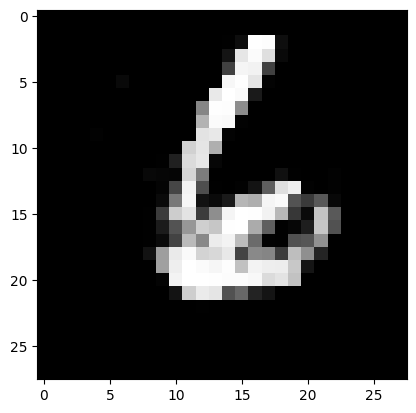

 68%|██████▊   | 34/50 [13:27<06:50, 25.64s/it]

Epoch: 34 Step: 0, discriminant loss: 1.1908328533172607

Epoch: 34, Step: 0, generator loss: 0.9190111756324768

Epoch: 34 Step: 250, discriminant loss: 1.2678651809692383

Epoch: 34, Step: 250, generator loss: 0.850356936454773

Epoch: 34 Step: 500, discriminant loss: 1.1854944229125977

Epoch: 34, Step: 500, generator loss: 0.9320463538169861

Epoch: 34 Step: 750, discriminant loss: 1.2459709644317627

Epoch: 34, Step: 750, generator loss: 1.0518443584442139


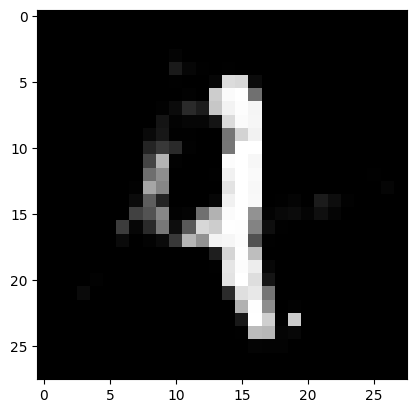

 70%|███████   | 35/50 [13:50<06:16, 25.07s/it]

Epoch: 35 Step: 0, discriminant loss: 1.1588611602783203

Epoch: 35, Step: 0, generator loss: 1.1034940481185913

Epoch: 35 Step: 250, discriminant loss: 1.2128002643585205

Epoch: 35, Step: 250, generator loss: 1.0265965461730957

Epoch: 35 Step: 500, discriminant loss: 1.1973214149475098

Epoch: 35, Step: 500, generator loss: 0.920005202293396

Epoch: 35 Step: 750, discriminant loss: 1.2375471591949463

Epoch: 35, Step: 750, generator loss: 0.9329997301101685


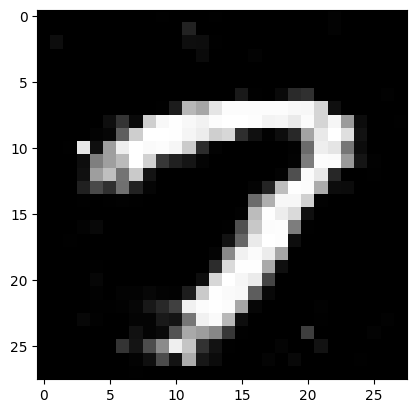

 72%|███████▏  | 36/50 [14:13<05:42, 24.45s/it]

Epoch: 36 Step: 0, discriminant loss: 1.2838289737701416

Epoch: 36, Step: 0, generator loss: 1.132602334022522

Epoch: 36 Step: 250, discriminant loss: 1.2201879024505615

Epoch: 36, Step: 250, generator loss: 0.74110347032547

Epoch: 36 Step: 500, discriminant loss: 1.199450135231018

Epoch: 36, Step: 500, generator loss: 1.0724560022354126

Epoch: 36 Step: 750, discriminant loss: 1.2761037349700928

Epoch: 36, Step: 750, generator loss: 0.91361403465271


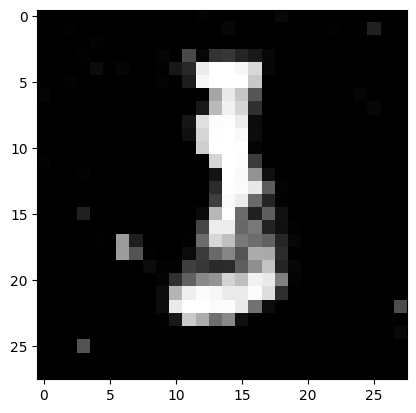

 74%|███████▍  | 37/50 [14:37<05:13, 24.12s/it]

Epoch: 37 Step: 0, discriminant loss: 1.12795889377594

Epoch: 37, Step: 0, generator loss: 1.1359424591064453

Epoch: 37 Step: 250, discriminant loss: 1.2203220129013062

Epoch: 37, Step: 250, generator loss: 1.1036373376846313

Epoch: 37 Step: 500, discriminant loss: 1.2503206729888916

Epoch: 37, Step: 500, generator loss: 0.9839961528778076

Epoch: 37 Step: 750, discriminant loss: 1.085531234741211

Epoch: 37, Step: 750, generator loss: 0.8884365558624268


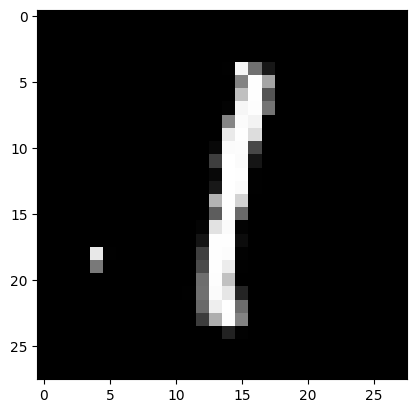

 76%|███████▌  | 38/50 [15:00<04:45, 23.80s/it]

Epoch: 38 Step: 0, discriminant loss: 1.1366209983825684

Epoch: 38, Step: 0, generator loss: 1.0788886547088623

Epoch: 38 Step: 250, discriminant loss: 1.261998176574707

Epoch: 38, Step: 250, generator loss: 1.169252872467041

Epoch: 38 Step: 500, discriminant loss: 1.3475005626678467

Epoch: 38, Step: 500, generator loss: 1.0094537734985352

Epoch: 38 Step: 750, discriminant loss: 1.1167359352111816

Epoch: 38, Step: 750, generator loss: 0.8606446385383606


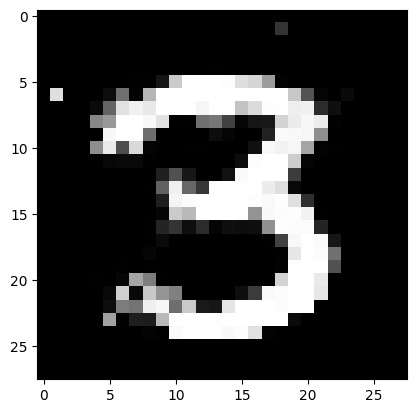

 78%|███████▊  | 39/50 [15:23<04:20, 23.64s/it]

Epoch: 39 Step: 0, discriminant loss: 1.1620142459869385

Epoch: 39, Step: 0, generator loss: 0.8884952068328857

Epoch: 39 Step: 250, discriminant loss: 1.2534757852554321

Epoch: 39, Step: 250, generator loss: 0.9624712467193604

Epoch: 39 Step: 500, discriminant loss: 1.1534584760665894

Epoch: 39, Step: 500, generator loss: 0.9434310793876648

Epoch: 39 Step: 750, discriminant loss: 1.2400872707366943

Epoch: 39, Step: 750, generator loss: 1.1476986408233643


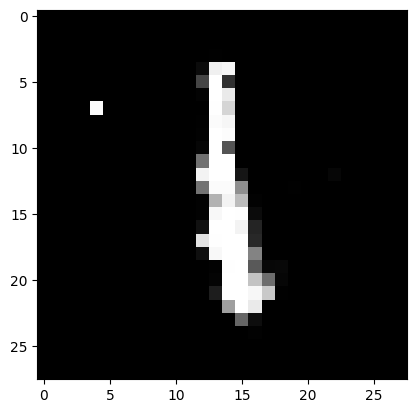

 80%|████████  | 40/50 [15:46<03:54, 23.49s/it]

Epoch: 40 Step: 0, discriminant loss: 1.2575840950012207

Epoch: 40, Step: 0, generator loss: 0.9010750651359558

Epoch: 40 Step: 250, discriminant loss: 1.2147634029388428

Epoch: 40, Step: 250, generator loss: 1.1862094402313232

Epoch: 40 Step: 500, discriminant loss: 1.1852306127548218

Epoch: 40, Step: 500, generator loss: 0.9247738718986511

Epoch: 40 Step: 750, discriminant loss: 1.2369329929351807

Epoch: 40, Step: 750, generator loss: 0.9938453435897827


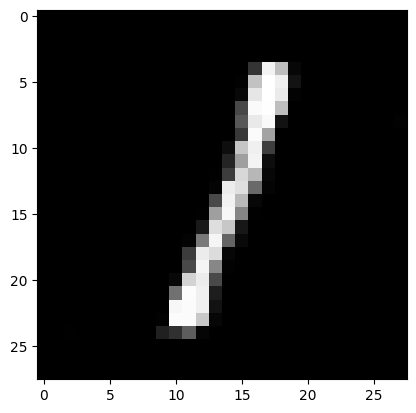

 82%|████████▏ | 41/50 [16:09<03:30, 23.37s/it]

Epoch: 41 Step: 0, discriminant loss: 1.1614570617675781

Epoch: 41, Step: 0, generator loss: 1.0102403163909912

Epoch: 41 Step: 250, discriminant loss: 1.124338984489441

Epoch: 41, Step: 250, generator loss: 0.9843648672103882

Epoch: 41 Step: 500, discriminant loss: 1.2162253856658936

Epoch: 41, Step: 500, generator loss: 0.9357656240463257

Epoch: 41 Step: 750, discriminant loss: 1.1636719703674316

Epoch: 41, Step: 750, generator loss: 1.0146615505218506


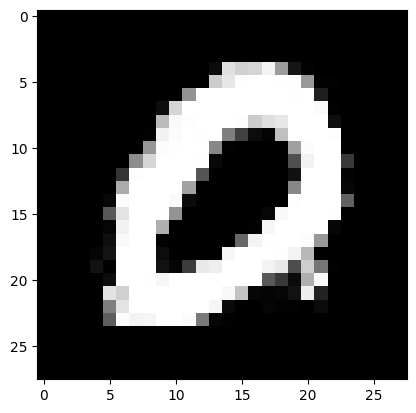

 84%|████████▍ | 42/50 [16:32<03:06, 23.27s/it]

Epoch: 42 Step: 0, discriminant loss: 1.022454857826233

Epoch: 42, Step: 0, generator loss: 1.0993475914001465

Epoch: 42 Step: 250, discriminant loss: 1.194663643836975

Epoch: 42, Step: 250, generator loss: 0.9092329740524292

Epoch: 42 Step: 500, discriminant loss: 1.2919971942901611

Epoch: 42, Step: 500, generator loss: 1.0621869564056396

Epoch: 42 Step: 750, discriminant loss: 1.2002606391906738

Epoch: 42, Step: 750, generator loss: 0.867961585521698


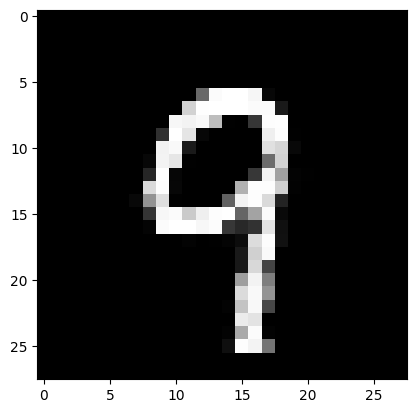

 86%|████████▌ | 43/50 [16:56<02:43, 23.30s/it]

Epoch: 43 Step: 0, discriminant loss: 1.141196846961975

Epoch: 43, Step: 0, generator loss: 0.9392555952072144

Epoch: 43 Step: 250, discriminant loss: 1.1761109828948975

Epoch: 43, Step: 250, generator loss: 0.9202889800071716

Epoch: 43 Step: 500, discriminant loss: 1.1972205638885498

Epoch: 43, Step: 500, generator loss: 0.7915011644363403

Epoch: 43 Step: 750, discriminant loss: 1.3170173168182373

Epoch: 43, Step: 750, generator loss: 1.2048754692077637


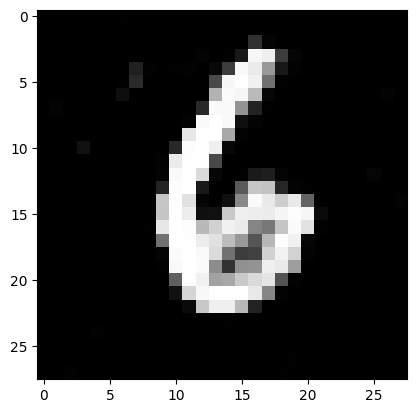

 88%|████████▊ | 44/50 [17:20<02:20, 23.43s/it]

Epoch: 44 Step: 0, discriminant loss: 1.1519215106964111

Epoch: 44, Step: 0, generator loss: 1.0994267463684082

Epoch: 44 Step: 250, discriminant loss: 1.2733166217803955

Epoch: 44, Step: 250, generator loss: 1.057375431060791

Epoch: 44 Step: 500, discriminant loss: 1.2085614204406738

Epoch: 44, Step: 500, generator loss: 1.0396175384521484

Epoch: 44 Step: 750, discriminant loss: 1.2988865375518799

Epoch: 44, Step: 750, generator loss: 0.8794270157814026


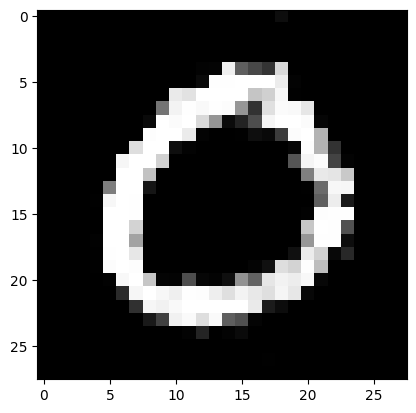

 90%|█████████ | 45/50 [17:43<01:57, 23.50s/it]

Epoch: 45 Step: 0, discriminant loss: 1.1746151447296143

Epoch: 45, Step: 0, generator loss: 0.9737982153892517

Epoch: 45 Step: 250, discriminant loss: 1.3053019046783447

Epoch: 45, Step: 250, generator loss: 0.9071812629699707

Epoch: 45 Step: 500, discriminant loss: 1.2698965072631836

Epoch: 45, Step: 500, generator loss: 0.7461330890655518

Epoch: 45 Step: 750, discriminant loss: 1.189483404159546

Epoch: 45, Step: 750, generator loss: 0.8787199258804321


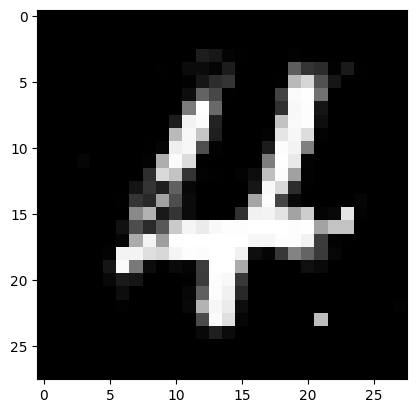

 92%|█████████▏| 46/50 [18:06<01:33, 23.41s/it]

Epoch: 46 Step: 0, discriminant loss: 1.271619200706482

Epoch: 46, Step: 0, generator loss: 1.1104727983474731

Epoch: 46 Step: 250, discriminant loss: 1.1637401580810547

Epoch: 46, Step: 250, generator loss: 1.0493435859680176

Epoch: 46 Step: 500, discriminant loss: 1.2080249786376953

Epoch: 46, Step: 500, generator loss: 0.8969113826751709

Epoch: 46 Step: 750, discriminant loss: 1.0961989164352417

Epoch: 46, Step: 750, generator loss: 0.8427094221115112


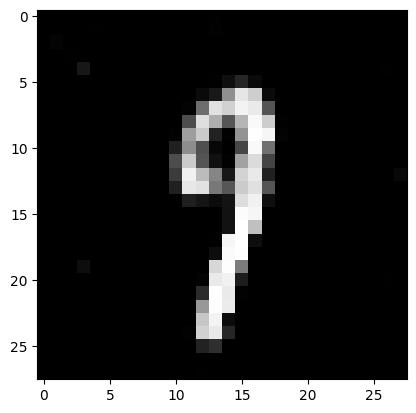

 94%|█████████▍| 47/50 [18:31<01:10, 23.63s/it]

Epoch: 47 Step: 0, discriminant loss: 1.2096816301345825

Epoch: 47, Step: 0, generator loss: 1.0222738981246948

Epoch: 47 Step: 250, discriminant loss: 1.190190315246582

Epoch: 47, Step: 250, generator loss: 0.9988927841186523

Epoch: 47 Step: 500, discriminant loss: 1.2590932846069336

Epoch: 47, Step: 500, generator loss: 1.1619592905044556

Epoch: 47 Step: 750, discriminant loss: 1.234162449836731

Epoch: 47, Step: 750, generator loss: 0.9595991969108582


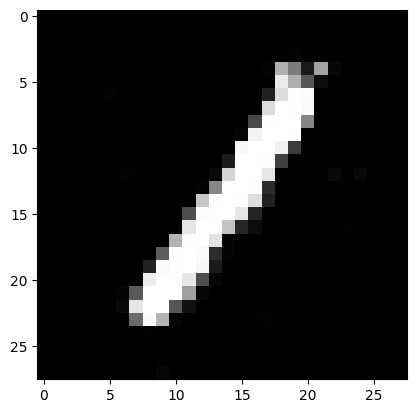

 96%|█████████▌| 48/50 [18:54<00:47, 23.57s/it]

Epoch: 48 Step: 0, discriminant loss: 1.1575710773468018

Epoch: 48, Step: 0, generator loss: 0.9021247625350952

Epoch: 48 Step: 250, discriminant loss: 1.257691502571106

Epoch: 48, Step: 250, generator loss: 0.9357950687408447

Epoch: 48 Step: 500, discriminant loss: 1.211236596107483

Epoch: 48, Step: 500, generator loss: 1.0984914302825928

Epoch: 48 Step: 750, discriminant loss: 1.1797707080841064

Epoch: 48, Step: 750, generator loss: 0.8894854784011841


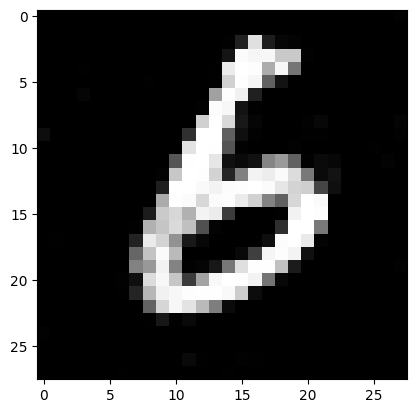

 98%|█████████▊| 49/50 [19:17<00:23, 23.47s/it]

Epoch: 49 Step: 0, discriminant loss: 1.2649223804473877

Epoch: 49, Step: 0, generator loss: 1.051954984664917

Epoch: 49 Step: 250, discriminant loss: 1.174907922744751

Epoch: 49, Step: 250, generator loss: 1.1108522415161133

Epoch: 49 Step: 500, discriminant loss: 1.1559786796569824

Epoch: 49, Step: 500, generator loss: 0.9534116387367249

Epoch: 49 Step: 750, discriminant loss: 1.1658759117126465

Epoch: 49, Step: 750, generator loss: 0.8416581749916077


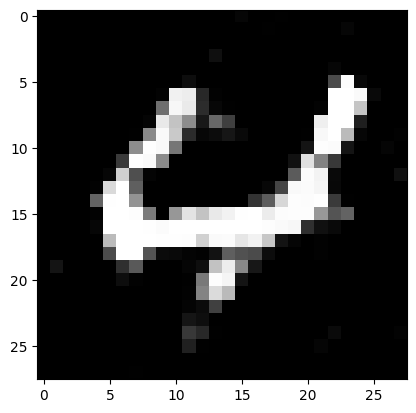

100%|██████████| 50/50 [19:40<00:00, 23.62s/it]


In [ ]:
loss_fn = nn.BCELoss()

generator, discriminator = train_gan(loss_fn = loss_fn,
                                     train_dataloader = train_dataloader,
                                     device = device)

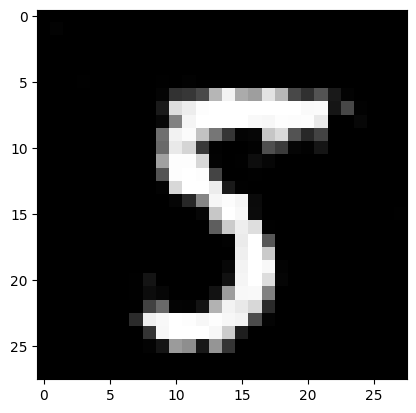

In [ ]:
test_noise = torch.randn(100).to(device)
generated_image = generator(test_noise)
plt.imshow(generated_image.squeeze().cpu().detach(), cmap = "gray")

In [ ]:
from pathlib import Path

model_path = Path("models")

torch.save(generator, model_path / "mnist" / "generator_mnist.pth")
torch.save(discriminator, model_path / "mnist" / "discriminator_mnist.pth")

##Training on faces

Now, to move on to the actual task: Creating fake faces using a GAN!

A good start would be torch's CelebA dataset

In [ ]:
%pip install gdown



















   ---------------------------------------- 0.0/147.9 kB ? eta -:--:--

   ---------------------------------------- 147.9/147.9 kB 2.9 MB/s eta 0:00:00





Note: you may need to restart the kernel to use updated packages.


In [14]:
celebA_transforms = transforms.Compose([ToTensor(),
                                       transforms.Normalize(0.5, 0.5),
                                       transforms.Resize((32, 32))])  # Testing on a smaller to image to see how our model will perform

celebA_train_data = datasets.CelebA(root = "data/celeba",
                                    split = "train",
                                    transform = celebA_transforms,
                                    download = True)

# celebA_train_data = datasets.CIFAR10(root = "data/cifar-10",
#                               train = True,
#                               transform = celebA_transforms,
#                               download = True)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=9788714c-0ecb-4f84-9bd9-869ddd3e06e8
To: /content/data/celeba/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:07<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 110MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 180MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /conte

torch.Size([3, 32, 32])


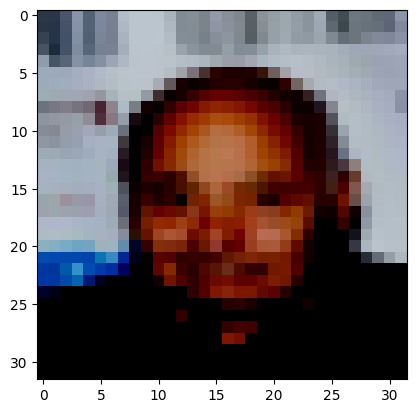

In [15]:
image, label = celebA_train_data[50]

plt.imshow(image.permute(1,2,0))
print(image.shape)

In [16]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(celebA_train_data,
                              BATCH_SIZE,
                              shuffle = True,
                              drop_last = True)

In [17]:
device

'cuda'

In [18]:
len(train_dataloader), len(next(iter(train_dataloader)))

(2543, 2)

##Creating a Deep Convolutional GAN

Now, this dataset is much, much larger than MNIST digits so our simple Vanilla GAN is incapable of learning anything more than the very basic idea and would also take long to train.

This is where our old friend CNN comes in.

A DCGAN is similar to a Vanilla GAN but both the Discriminator and Generator use Convolutional layers to classify and generate the images respectively.

The structure of the Generator starts the same as Vanilla but in the first step it uses an MLP to convert the 100 dimensional noise into (4\*4\*256) dimensions.
This is then resized to (4, 4, 256) and then sent to successive ConvTranspose2d blocks and a final conv2d layer which this to (32, 32, 3)

A Transposed Convolution goes from a small image size to a larger one. An intuitive way to understand this can be is that it first reconstructs what kind of image size could have led to our current shape if it was a normal convolution, and then the calculation goes from there.
A good graphic for this is from 2:40 onwards in https://www.youtube.com/watch?v=96_oGE8WyPg

These are all followed with ReLU and LeakyReLU for the mlp and conv layers respectively and tanh at the end to clamp between -1 to 1

Added note: This structure can be thought of as us starting with multiple smaller versions (256) x (4x4) of our actual image.
In all 3 ConvTranspose2d layers, we turn this into 128 possibilities and slowly convert these 4x4 images to 32 x 32 (3 layers).
All of these 128 possibilities are then crushed into a single image with 3 channels and 32 x 32 shape with a Conv2d layer

In [19]:
class DCGenerator(nn.Module):  # Funny name
  def __init__(self,
               input_shape: int = 100,
               output_shape: int = 32):
    super().__init__()

    self.mlp = nn.Sequential(
        nn.Linear(input_shape, 4*4*256),
        nn.LeakyReLU(0.2)
    )

    self.conv1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1),
                               nn.LeakyReLU(0.2))
    self.conv2 = nn.Sequential(nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1),
                               nn.LeakyReLU(0.2))
    self.conv3 = nn.Sequential(nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1),
                               nn.LeakyReLU(0.2))
    self.conv4 = nn.Sequential(nn.Conv2d(128, 3, kernel_size = 3, padding = 1),
                               nn.Tanh())

  def forward(self, x: torch.Tensor):
    x = self.mlp(x)
    x = x.view(-1, 256, 4, 4)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    return x

torch.Size([1, 3, 32, 32])
tensor(0.0374, grad_fn=<MaxBackward1>) tensor(-0.0234, grad_fn=<MinBackward1>)
tensor(0.5374, grad_fn=<MaxBackward1>) tensor(0.4766, grad_fn=<MinBackward1>)


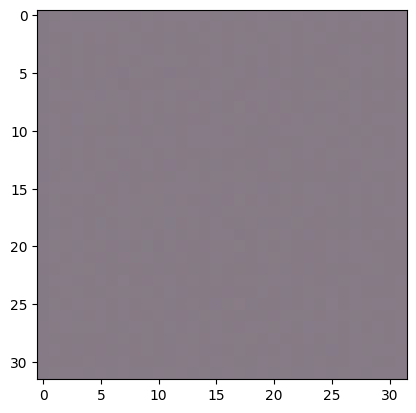

In [20]:
noise = torch.randn(1, 100)
generator = DCGenerator()
gen_output = generator(noise)
print(gen_output.shape)
print(gen_output.max(), gen_output.min())

gen_output[:] = gen_output + 1 / 2
print(gen_output.max(), gen_output.min())

plt.imshow(gen_output.squeeze().detach().permute(1,2,0))

Now, the discriminator is a normal CNN binary classifier

In [21]:
class DCDiscriminator(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               num_classes: int = 1):
    super().__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size = 3, padding = 1),
                               nn.LeakyReLU(0.2))
    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding =1),
                               nn.LeakyReLU(0.2))
    self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1),
                               nn.LeakyReLU(0.2))
    self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
                               nn.LeakyReLU(0.2))

    self.mlp = nn.Sequential(nn.Flatten(),
                             nn.Dropout(0.4),
                             nn.Linear(4*4*256, 1),
                             nn.Sigmoid())


  def forward(self, x: torch.Tensor):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.mlp(x)
    return x


In [22]:
discriminator = DCDiscriminator()
disc_output = discriminator(gen_output)
disc_output

tensor([[0.5006]], grad_fn=<SigmoidBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 Step: 0, discriminant loss: 1.3824989795684814
Epoch: 0, Step: 0, generator loss: 0.6978329420089722
Epoch: 0 Step: 250, discriminant loss: 0.06367772817611694
Epoch: 0, Step: 250, generator loss: 5.066431999206543
Epoch: 0 Step: 500, discriminant loss: 0.016885139048099518
Epoch: 0, Step: 500, generator loss: 18.32302474975586
Epoch: 0 Step: 750, discriminant loss: 0.000653452705591917
Epoch: 0, Step: 750, generator loss: 7.841096878051758
Epoch: 0 Step: 1000, discriminant loss: 0.0892154723405838
Epoch: 0, Step: 1000, generator loss: 5.480749130249023
Epoch: 0 Step: 1250, discriminant loss: 0.49198704957962036
Epoch: 0, Step: 1250, generator loss: 2.0987844467163086
Epoch: 0 Step: 1500, discriminant loss: 0.6175416707992554
Epoch: 0, Step: 1500, generator loss: 1.5152232646942139
Epoch: 0 Step: 1750, discriminant loss: 1.0284860134124756
Epoch: 0, Step: 1750, generator loss: 1.214547872543335
Epoch: 0 Step: 2000, discriminant loss: 1.1369731426239014
Epoch: 0, Step: 2000, ge

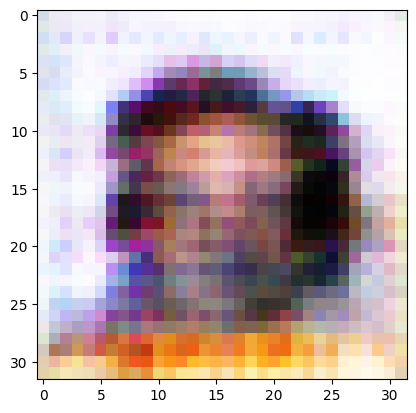

Epoch: 1 Step: 0, discriminant loss: 0.9437618255615234
Epoch: 1, Step: 0, generator loss: 1.4350218772888184
Epoch: 1 Step: 250, discriminant loss: 1.1969835758209229
Epoch: 1, Step: 250, generator loss: 0.9317271709442139
Epoch: 1 Step: 500, discriminant loss: 0.9325971603393555
Epoch: 1, Step: 500, generator loss: 1.4173264503479004
Epoch: 1 Step: 750, discriminant loss: 0.7518333792686462
Epoch: 1, Step: 750, generator loss: 1.1805131435394287
Epoch: 1 Step: 1000, discriminant loss: 1.0844460725784302
Epoch: 1, Step: 1000, generator loss: 1.2058918476104736
Epoch: 1 Step: 1250, discriminant loss: 0.9209328889846802
Epoch: 1, Step: 1250, generator loss: 1.6542294025421143
Epoch: 1 Step: 1500, discriminant loss: 0.8681270480155945
Epoch: 1, Step: 1500, generator loss: 1.5213873386383057
Epoch: 1 Step: 1750, discriminant loss: 0.9385140538215637
Epoch: 1, Step: 1750, generator loss: 1.1909575462341309
Epoch: 1 Step: 2000, discriminant loss: 0.9399022459983826
Epoch: 1, Step: 2000, gen

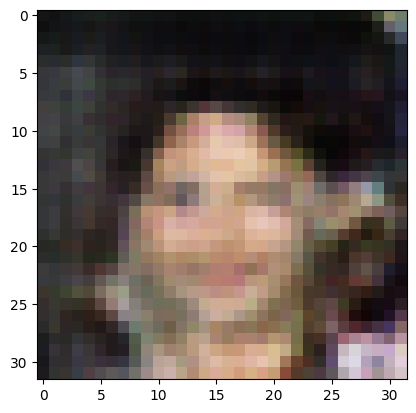

Epoch: 2 Step: 0, discriminant loss: 0.9780406355857849
Epoch: 2, Step: 0, generator loss: 1.3563485145568848
Epoch: 2 Step: 250, discriminant loss: 1.108176827430725
Epoch: 2, Step: 250, generator loss: 1.1354343891143799
Epoch: 2 Step: 500, discriminant loss: 1.3030872344970703
Epoch: 2, Step: 500, generator loss: 1.1737630367279053
Epoch: 2 Step: 750, discriminant loss: 1.032008409500122
Epoch: 2, Step: 750, generator loss: 1.1967426538467407
Epoch: 2 Step: 1000, discriminant loss: 1.152522325515747
Epoch: 2, Step: 1000, generator loss: 1.1228997707366943
Epoch: 2 Step: 1250, discriminant loss: 1.233178734779358
Epoch: 2, Step: 1250, generator loss: 0.99386066198349
Epoch: 2 Step: 1500, discriminant loss: 1.1920015811920166
Epoch: 2, Step: 1500, generator loss: 1.1438668966293335
Epoch: 2 Step: 1750, discriminant loss: 1.076643943786621
Epoch: 2, Step: 1750, generator loss: 1.1875211000442505
Epoch: 2 Step: 2000, discriminant loss: 1.2901597023010254
Epoch: 2, Step: 2000, generator 

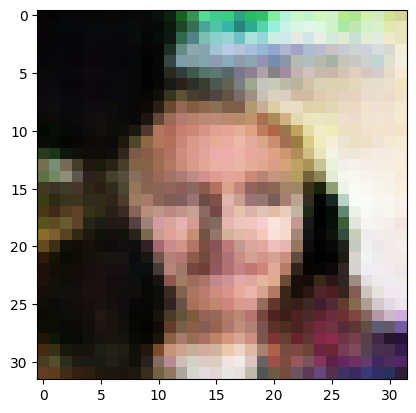

Epoch: 3 Step: 0, discriminant loss: 1.0310684442520142
Epoch: 3, Step: 0, generator loss: 1.0845847129821777
Epoch: 3 Step: 250, discriminant loss: 1.1739752292633057
Epoch: 3, Step: 250, generator loss: 1.2209054231643677
Epoch: 3 Step: 500, discriminant loss: 1.1679747104644775
Epoch: 3, Step: 500, generator loss: 1.00266432762146
Epoch: 3 Step: 750, discriminant loss: 1.2375872135162354
Epoch: 3, Step: 750, generator loss: 0.9850082397460938
Epoch: 3 Step: 1000, discriminant loss: 1.4160979986190796
Epoch: 3, Step: 1000, generator loss: 1.3998117446899414
Epoch: 3 Step: 1250, discriminant loss: 1.175261378288269
Epoch: 3, Step: 1250, generator loss: 0.9525244235992432
Epoch: 3 Step: 1500, discriminant loss: 1.187995433807373
Epoch: 3, Step: 1500, generator loss: 1.2429664134979248
Epoch: 3 Step: 1750, discriminant loss: 1.2313401699066162
Epoch: 3, Step: 1750, generator loss: 1.013638973236084
Epoch: 3 Step: 2000, discriminant loss: 1.051653504371643
Epoch: 3, Step: 2000, generator

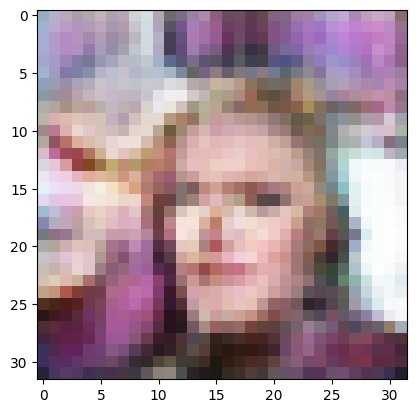

Epoch: 4 Step: 0, discriminant loss: 0.8724081516265869
Epoch: 4, Step: 0, generator loss: 1.2792739868164062
Epoch: 4 Step: 250, discriminant loss: 1.2084031105041504
Epoch: 4, Step: 250, generator loss: 1.4870139360427856
Epoch: 4 Step: 500, discriminant loss: 1.1743786334991455
Epoch: 4, Step: 500, generator loss: 1.04380464553833
Epoch: 4 Step: 750, discriminant loss: 1.1258138418197632
Epoch: 4, Step: 750, generator loss: 1.027106523513794
Epoch: 4 Step: 1000, discriminant loss: 1.08739173412323
Epoch: 4, Step: 1000, generator loss: 1.038793683052063
Epoch: 4 Step: 1250, discriminant loss: 1.0309343338012695
Epoch: 4, Step: 1250, generator loss: 0.9908751249313354
Epoch: 4 Step: 1500, discriminant loss: 1.0655784606933594
Epoch: 4, Step: 1500, generator loss: 1.178006887435913
Epoch: 4 Step: 1750, discriminant loss: 1.0571794509887695
Epoch: 4, Step: 1750, generator loss: 0.9766172170639038
Epoch: 4 Step: 2000, discriminant loss: 1.2689735889434814
Epoch: 4, Step: 2000, generator 

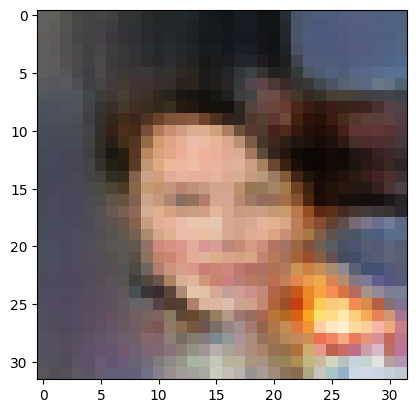

Epoch: 5 Step: 0, discriminant loss: 1.1422975063323975
Epoch: 5, Step: 0, generator loss: 1.1731736660003662
Epoch: 5 Step: 250, discriminant loss: 1.0846577882766724
Epoch: 5, Step: 250, generator loss: 1.1238393783569336
Epoch: 5 Step: 500, discriminant loss: 1.2049922943115234
Epoch: 5, Step: 500, generator loss: 1.1798633337020874
Epoch: 5 Step: 750, discriminant loss: 1.2273752689361572
Epoch: 5, Step: 750, generator loss: 1.1294829845428467
Epoch: 5 Step: 1000, discriminant loss: 1.1471619606018066
Epoch: 5, Step: 1000, generator loss: 0.988662600517273
Epoch: 5 Step: 1250, discriminant loss: 1.1768519878387451
Epoch: 5, Step: 1250, generator loss: 1.1518248319625854
Epoch: 5 Step: 1500, discriminant loss: 1.1128222942352295
Epoch: 5, Step: 1500, generator loss: 0.9967700839042664
Epoch: 5 Step: 1750, discriminant loss: 1.0625426769256592
Epoch: 5, Step: 1750, generator loss: 1.1400989294052124
Epoch: 5 Step: 2000, discriminant loss: 1.2149049043655396
Epoch: 5, Step: 2000, gene

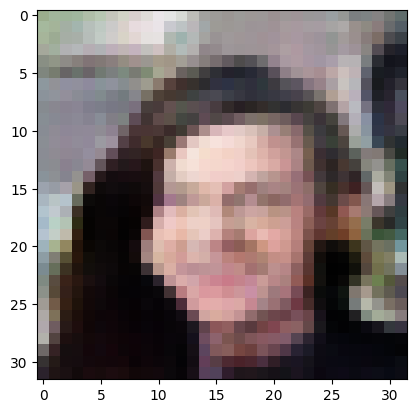

Epoch: 6 Step: 0, discriminant loss: 1.2545686960220337
Epoch: 6, Step: 0, generator loss: 1.0180619955062866
Epoch: 6 Step: 250, discriminant loss: 1.281954050064087
Epoch: 6, Step: 250, generator loss: 0.9818440675735474
Epoch: 6 Step: 500, discriminant loss: 1.0859973430633545
Epoch: 6, Step: 500, generator loss: 0.8360798358917236
Epoch: 6 Step: 750, discriminant loss: 1.0417814254760742
Epoch: 6, Step: 750, generator loss: 1.1589205265045166
Epoch: 6 Step: 1000, discriminant loss: 1.1811392307281494
Epoch: 6, Step: 1000, generator loss: 1.0291513204574585
Epoch: 6 Step: 1250, discriminant loss: 1.1692949533462524
Epoch: 6, Step: 1250, generator loss: 1.092885136604309
Epoch: 6 Step: 1500, discriminant loss: 1.063793420791626
Epoch: 6, Step: 1500, generator loss: 1.1329078674316406
Epoch: 6 Step: 1750, discriminant loss: 1.1349626779556274
Epoch: 6, Step: 1750, generator loss: 0.9980910420417786
Epoch: 6 Step: 2000, discriminant loss: 1.1520025730133057
Epoch: 6, Step: 2000, genera

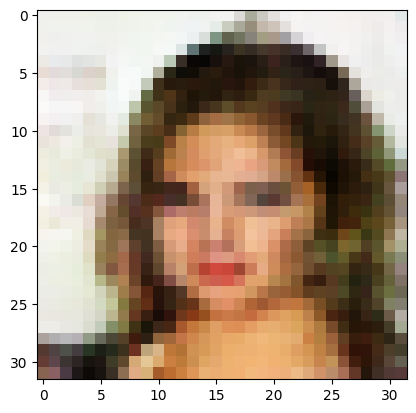

Epoch: 7 Step: 0, discriminant loss: 1.062821626663208
Epoch: 7, Step: 0, generator loss: 1.3485174179077148
Epoch: 7 Step: 250, discriminant loss: 1.086141586303711
Epoch: 7, Step: 250, generator loss: 0.9044385552406311
Epoch: 7 Step: 500, discriminant loss: 1.032711386680603
Epoch: 7, Step: 500, generator loss: 1.0534446239471436
Epoch: 7 Step: 750, discriminant loss: 1.1171759366989136
Epoch: 7, Step: 750, generator loss: 0.8817747235298157
Epoch: 7 Step: 1000, discriminant loss: 1.3923852443695068
Epoch: 7, Step: 1000, generator loss: 1.1229223012924194
Epoch: 7 Step: 1250, discriminant loss: 1.114710807800293
Epoch: 7, Step: 1250, generator loss: 1.0879416465759277
Epoch: 7 Step: 1500, discriminant loss: 1.1946159601211548
Epoch: 7, Step: 1500, generator loss: 1.1233984231948853
Epoch: 7 Step: 1750, discriminant loss: 1.2218594551086426
Epoch: 7, Step: 1750, generator loss: 1.1157208681106567
Epoch: 7 Step: 2000, discriminant loss: 1.2450733184814453
Epoch: 7, Step: 2000, generat

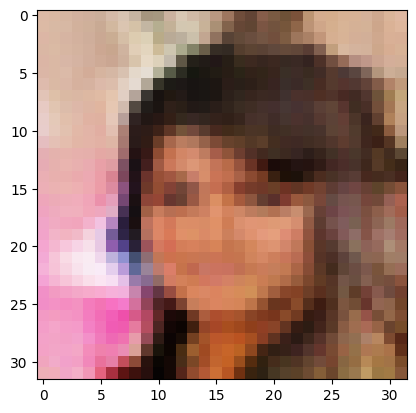

Epoch: 8 Step: 0, discriminant loss: 1.0142515897750854
Epoch: 8, Step: 0, generator loss: 1.1975653171539307
Epoch: 8 Step: 250, discriminant loss: 1.0261344909667969
Epoch: 8, Step: 250, generator loss: 1.136307954788208
Epoch: 8 Step: 500, discriminant loss: 1.1313073635101318
Epoch: 8, Step: 500, generator loss: 0.865777850151062
Epoch: 8 Step: 750, discriminant loss: 1.1109569072723389
Epoch: 8, Step: 750, generator loss: 1.2845652103424072
Epoch: 8 Step: 1000, discriminant loss: 1.2562596797943115
Epoch: 8, Step: 1000, generator loss: 0.7812979817390442
Epoch: 8 Step: 1250, discriminant loss: 1.153268575668335
Epoch: 8, Step: 1250, generator loss: 1.0342400074005127
Epoch: 8 Step: 1500, discriminant loss: 1.348198413848877
Epoch: 8, Step: 1500, generator loss: 1.2116162776947021
Epoch: 8 Step: 1750, discriminant loss: 1.164278507232666
Epoch: 8, Step: 1750, generator loss: 1.3372217416763306
Epoch: 8 Step: 2000, discriminant loss: 1.271308422088623
Epoch: 8, Step: 2000, generator

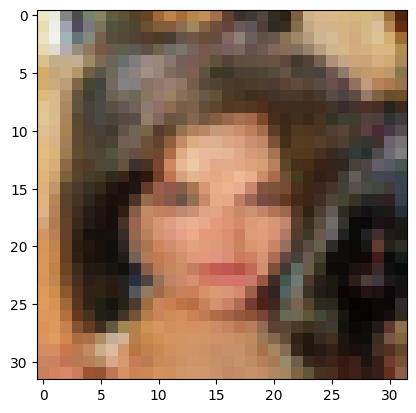

Epoch: 9 Step: 0, discriminant loss: 1.0783214569091797
Epoch: 9, Step: 0, generator loss: 1.1720516681671143
Epoch: 9 Step: 250, discriminant loss: 1.0912350416183472
Epoch: 9, Step: 250, generator loss: 1.2559175491333008
Epoch: 9 Step: 500, discriminant loss: 1.1065552234649658
Epoch: 9, Step: 500, generator loss: 1.2025195360183716
Epoch: 9 Step: 750, discriminant loss: 1.1040213108062744
Epoch: 9, Step: 750, generator loss: 1.161733627319336
Epoch: 9 Step: 1000, discriminant loss: 1.1317095756530762
Epoch: 9, Step: 1000, generator loss: 1.0168880224227905
Epoch: 9 Step: 1250, discriminant loss: 1.2248022556304932
Epoch: 9, Step: 1250, generator loss: 1.222353219985962
Epoch: 9 Step: 1500, discriminant loss: 0.9673566222190857
Epoch: 9, Step: 1500, generator loss: 0.8591861724853516
Epoch: 9 Step: 1750, discriminant loss: 1.3072361946105957
Epoch: 9, Step: 1750, generator loss: 1.1079232692718506
Epoch: 9 Step: 2000, discriminant loss: 1.1011098623275757
Epoch: 9, Step: 2000, gener

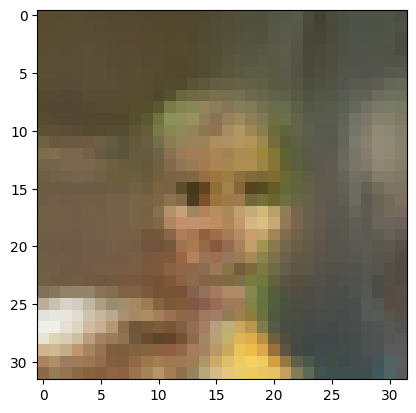

Epoch: 10 Step: 0, discriminant loss: 1.0696165561676025
Epoch: 10, Step: 0, generator loss: 1.2224560976028442
Epoch: 10 Step: 250, discriminant loss: 1.1721704006195068
Epoch: 10, Step: 250, generator loss: 1.1731252670288086
Epoch: 10 Step: 500, discriminant loss: 0.9897395372390747
Epoch: 10, Step: 500, generator loss: 1.0360764265060425
Epoch: 10 Step: 750, discriminant loss: 1.034557819366455
Epoch: 10, Step: 750, generator loss: 1.0462672710418701
Epoch: 10 Step: 1000, discriminant loss: 1.2808758020401
Epoch: 10, Step: 1000, generator loss: 1.4975165128707886
Epoch: 10 Step: 1250, discriminant loss: 1.057822346687317
Epoch: 10, Step: 1250, generator loss: 0.9247275590896606
Epoch: 10 Step: 1500, discriminant loss: 1.1130824089050293
Epoch: 10, Step: 1500, generator loss: 1.2041605710983276
Epoch: 10 Step: 1750, discriminant loss: 1.1817054748535156
Epoch: 10, Step: 1750, generator loss: 0.9334627389907837
Epoch: 10 Step: 2000, discriminant loss: 1.1283875703811646
Epoch: 10, St

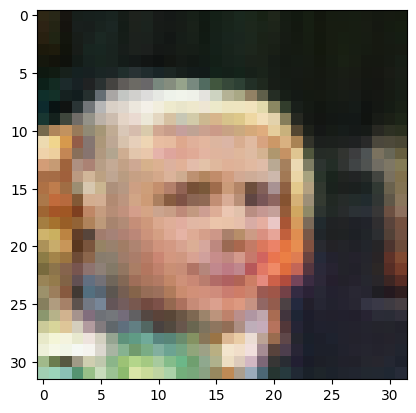

Epoch: 11 Step: 0, discriminant loss: 1.1902570724487305
Epoch: 11, Step: 0, generator loss: 1.0305832624435425
Epoch: 11 Step: 250, discriminant loss: 1.1292448043823242
Epoch: 11, Step: 250, generator loss: 1.12626314163208
Epoch: 11 Step: 500, discriminant loss: 1.2002978324890137
Epoch: 11, Step: 500, generator loss: 1.562150001525879
Epoch: 11 Step: 750, discriminant loss: 1.0397624969482422
Epoch: 11, Step: 750, generator loss: 0.9384419918060303
Epoch: 11 Step: 1000, discriminant loss: 1.098877191543579
Epoch: 11, Step: 1000, generator loss: 1.0294253826141357
Epoch: 11 Step: 1250, discriminant loss: 1.0213215351104736
Epoch: 11, Step: 1250, generator loss: 1.3292858600616455
Epoch: 11 Step: 1500, discriminant loss: 1.2045890092849731
Epoch: 11, Step: 1500, generator loss: 1.1516281366348267
Epoch: 11 Step: 1750, discriminant loss: 1.1855427026748657
Epoch: 11, Step: 1750, generator loss: 0.9816114902496338
Epoch: 11 Step: 2000, discriminant loss: 1.1252694129943848
Epoch: 11, S

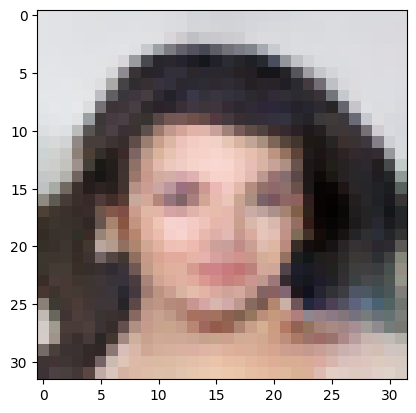

Epoch: 12 Step: 0, discriminant loss: 1.0834226608276367
Epoch: 12, Step: 0, generator loss: 1.132835865020752
Epoch: 12 Step: 250, discriminant loss: 1.202149510383606
Epoch: 12, Step: 250, generator loss: 1.1842682361602783
Epoch: 12 Step: 500, discriminant loss: 1.1852463483810425
Epoch: 12, Step: 500, generator loss: 1.4871416091918945
Epoch: 12 Step: 750, discriminant loss: 1.1715797185897827
Epoch: 12, Step: 750, generator loss: 0.9385849833488464
Epoch: 12 Step: 1000, discriminant loss: 1.1810234785079956
Epoch: 12, Step: 1000, generator loss: 1.058558702468872
Epoch: 12 Step: 1250, discriminant loss: 1.0131207704544067
Epoch: 12, Step: 1250, generator loss: 1.0065284967422485
Epoch: 12 Step: 1500, discriminant loss: 1.0438287258148193
Epoch: 12, Step: 1500, generator loss: 1.0874526500701904
Epoch: 12 Step: 1750, discriminant loss: 1.1874840259552002
Epoch: 12, Step: 1750, generator loss: 1.4321097135543823
Epoch: 12 Step: 2000, discriminant loss: 1.0211257934570312
Epoch: 12, 

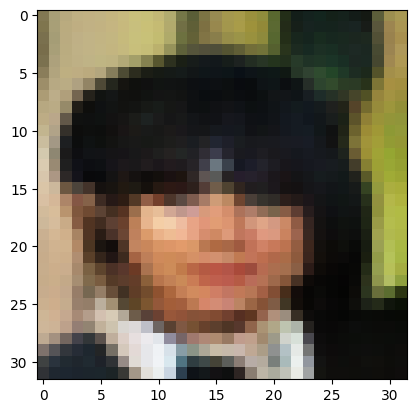

Epoch: 13 Step: 0, discriminant loss: 1.1916322708129883
Epoch: 13, Step: 0, generator loss: 0.9335960149765015
Epoch: 13 Step: 250, discriminant loss: 1.1954536437988281
Epoch: 13, Step: 250, generator loss: 1.386167287826538
Epoch: 13 Step: 500, discriminant loss: 1.071542739868164
Epoch: 13, Step: 500, generator loss: 1.0842684507369995
Epoch: 13 Step: 750, discriminant loss: 1.1565618515014648
Epoch: 13, Step: 750, generator loss: 1.1927275657653809
Epoch: 13 Step: 1000, discriminant loss: 1.2032967805862427
Epoch: 13, Step: 1000, generator loss: 1.3029069900512695
Epoch: 13 Step: 1250, discriminant loss: 1.117619514465332
Epoch: 13, Step: 1250, generator loss: 1.2171962261199951
Epoch: 13 Step: 1500, discriminant loss: 1.0143113136291504
Epoch: 13, Step: 1500, generator loss: 0.9912888407707214
Epoch: 13 Step: 1750, discriminant loss: 1.0722323656082153
Epoch: 13, Step: 1750, generator loss: 0.9599777460098267
Epoch: 13 Step: 2000, discriminant loss: 1.2555766105651855
Epoch: 13, 

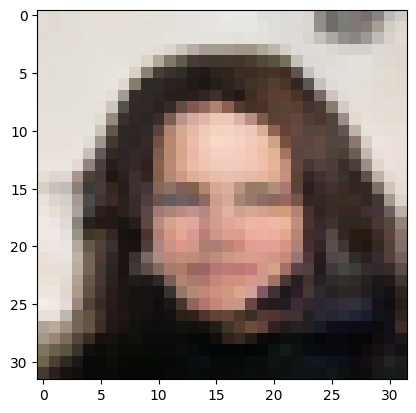

Epoch: 14 Step: 0, discriminant loss: 1.1148045063018799
Epoch: 14, Step: 0, generator loss: 1.397523283958435
Epoch: 14 Step: 250, discriminant loss: 1.1284528970718384
Epoch: 14, Step: 250, generator loss: 1.082162857055664
Epoch: 14 Step: 500, discriminant loss: 1.1290919780731201
Epoch: 14, Step: 500, generator loss: 1.2273212671279907
Epoch: 14 Step: 750, discriminant loss: 1.0992193222045898
Epoch: 14, Step: 750, generator loss: 1.1573996543884277
Epoch: 14 Step: 1000, discriminant loss: 1.042607307434082
Epoch: 14, Step: 1000, generator loss: 1.1587610244750977
Epoch: 14 Step: 1250, discriminant loss: 1.2149393558502197
Epoch: 14, Step: 1250, generator loss: 1.2473174333572388
Epoch: 14 Step: 1500, discriminant loss: 0.9138252139091492
Epoch: 14, Step: 1500, generator loss: 1.1179134845733643
Epoch: 14 Step: 1750, discriminant loss: 0.9595508575439453
Epoch: 14, Step: 1750, generator loss: 1.0436511039733887
Epoch: 14 Step: 2000, discriminant loss: 1.1936293840408325
Epoch: 14, 

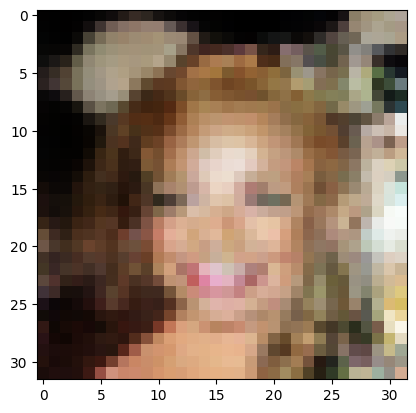

Epoch: 15 Step: 0, discriminant loss: 1.0262482166290283
Epoch: 15, Step: 0, generator loss: 0.9467556476593018
Epoch: 15 Step: 250, discriminant loss: 1.0900522470474243
Epoch: 15, Step: 250, generator loss: 1.1913800239562988
Epoch: 15 Step: 500, discriminant loss: 1.0645874738693237
Epoch: 15, Step: 500, generator loss: 1.5428731441497803
Epoch: 15 Step: 750, discriminant loss: 1.0932133197784424
Epoch: 15, Step: 750, generator loss: 1.1705710887908936
Epoch: 15 Step: 1000, discriminant loss: 1.1121041774749756
Epoch: 15, Step: 1000, generator loss: 1.0123037099838257
Epoch: 15 Step: 1250, discriminant loss: 0.9736062288284302
Epoch: 15, Step: 1250, generator loss: 1.2646923065185547
Epoch: 15 Step: 1500, discriminant loss: 1.0053074359893799
Epoch: 15, Step: 1500, generator loss: 1.1072545051574707
Epoch: 15 Step: 1750, discriminant loss: 1.1960361003875732
Epoch: 15, Step: 1750, generator loss: 1.0277040004730225
Epoch: 15 Step: 2000, discriminant loss: 1.0530081987380981
Epoch: 1

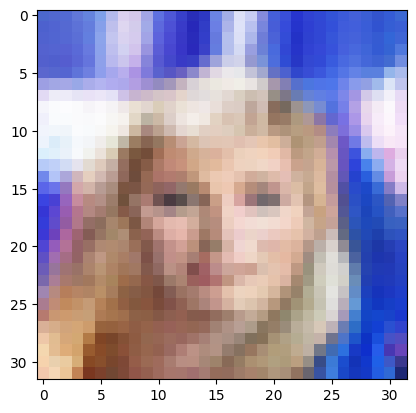

Epoch: 16 Step: 0, discriminant loss: 0.9048251509666443
Epoch: 16, Step: 0, generator loss: 1.268550157546997
Epoch: 16 Step: 250, discriminant loss: 1.090533971786499
Epoch: 16, Step: 250, generator loss: 0.9731744527816772
Epoch: 16 Step: 500, discriminant loss: 1.107907772064209
Epoch: 16, Step: 500, generator loss: 1.132882833480835
Epoch: 16 Step: 750, discriminant loss: 1.2432641983032227
Epoch: 16, Step: 750, generator loss: 1.1615115404129028
Epoch: 16 Step: 1000, discriminant loss: 1.1492061614990234
Epoch: 16, Step: 1000, generator loss: 1.166229009628296
Epoch: 16 Step: 1250, discriminant loss: 1.1898846626281738
Epoch: 16, Step: 1250, generator loss: 0.8981356620788574
Epoch: 16 Step: 1500, discriminant loss: 1.208144187927246
Epoch: 16, Step: 1500, generator loss: 0.8260946273803711
Epoch: 16 Step: 1750, discriminant loss: 1.183586597442627
Epoch: 16, Step: 1750, generator loss: 1.242081642150879
Epoch: 16 Step: 2000, discriminant loss: 1.1287518739700317
Epoch: 16, Step:

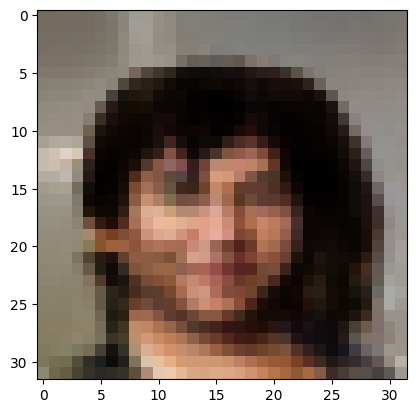

Epoch: 17 Step: 0, discriminant loss: 1.0884103775024414
Epoch: 17, Step: 0, generator loss: 1.1861846446990967
Epoch: 17 Step: 250, discriminant loss: 1.0243644714355469
Epoch: 17, Step: 250, generator loss: 1.1454367637634277
Epoch: 17 Step: 500, discriminant loss: 0.9662041664123535
Epoch: 17, Step: 500, generator loss: 1.4884289503097534
Epoch: 17 Step: 750, discriminant loss: 1.0609458684921265
Epoch: 17, Step: 750, generator loss: 1.4932122230529785
Epoch: 17 Step: 1000, discriminant loss: 1.1486883163452148
Epoch: 17, Step: 1000, generator loss: 1.2706027030944824
Epoch: 17 Step: 1250, discriminant loss: 1.0011287927627563
Epoch: 17, Step: 1250, generator loss: 1.0426807403564453
Epoch: 17 Step: 1500, discriminant loss: 1.2476524114608765
Epoch: 17, Step: 1500, generator loss: 1.1607942581176758
Epoch: 17 Step: 1750, discriminant loss: 1.1021835803985596
Epoch: 17, Step: 1750, generator loss: 1.2813713550567627
Epoch: 17 Step: 2000, discriminant loss: 0.9942782521247864
Epoch: 1

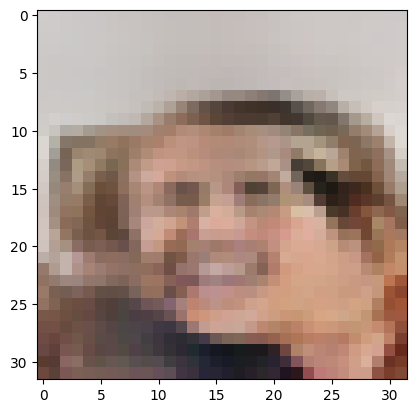

Epoch: 18 Step: 0, discriminant loss: 1.20127272605896
Epoch: 18, Step: 0, generator loss: 0.837457001209259
Epoch: 18 Step: 250, discriminant loss: 0.9449596405029297
Epoch: 18, Step: 250, generator loss: 1.077772855758667
Epoch: 18 Step: 500, discriminant loss: 1.0846272706985474
Epoch: 18, Step: 500, generator loss: 1.1944464445114136
Epoch: 18 Step: 750, discriminant loss: 1.1122472286224365
Epoch: 18, Step: 750, generator loss: 1.1585891246795654
Epoch: 18 Step: 1000, discriminant loss: 1.1112236976623535
Epoch: 18, Step: 1000, generator loss: 1.8040318489074707
Epoch: 18 Step: 1250, discriminant loss: 0.9333627223968506
Epoch: 18, Step: 1250, generator loss: 1.1613727807998657
Epoch: 18 Step: 1500, discriminant loss: 1.1607775688171387
Epoch: 18, Step: 1500, generator loss: 1.2245532274246216
Epoch: 18 Step: 1750, discriminant loss: 0.9205851554870605
Epoch: 18, Step: 1750, generator loss: 1.1375240087509155
Epoch: 18 Step: 2000, discriminant loss: 1.1712355613708496
Epoch: 18, S

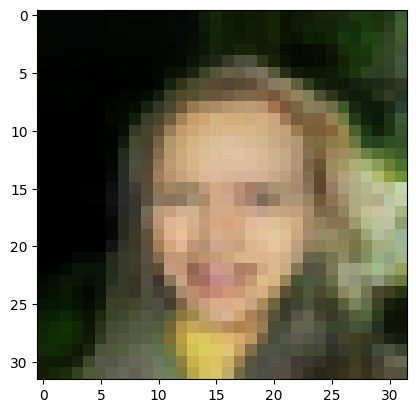

Epoch: 19 Step: 0, discriminant loss: 1.0078556537628174
Epoch: 19, Step: 0, generator loss: 1.012063980102539
Epoch: 19 Step: 250, discriminant loss: 0.9042301177978516
Epoch: 19, Step: 250, generator loss: 1.238354206085205
Epoch: 19 Step: 500, discriminant loss: 1.0752007961273193
Epoch: 19, Step: 500, generator loss: 0.9383609294891357
Epoch: 19 Step: 750, discriminant loss: 1.2071270942687988
Epoch: 19, Step: 750, generator loss: 1.4202618598937988
Epoch: 19 Step: 1000, discriminant loss: 1.0803048610687256
Epoch: 19, Step: 1000, generator loss: 1.096282720565796
Epoch: 19 Step: 1250, discriminant loss: 0.9528086185455322
Epoch: 19, Step: 1250, generator loss: 1.1107497215270996
Epoch: 19 Step: 1500, discriminant loss: 1.0670562982559204
Epoch: 19, Step: 1500, generator loss: 1.5704765319824219
Epoch: 19 Step: 1750, discriminant loss: 1.2853472232818604
Epoch: 19, Step: 1750, generator loss: 1.8020060062408447
Epoch: 19 Step: 2000, discriminant loss: 0.9956106543540955
Epoch: 19, 

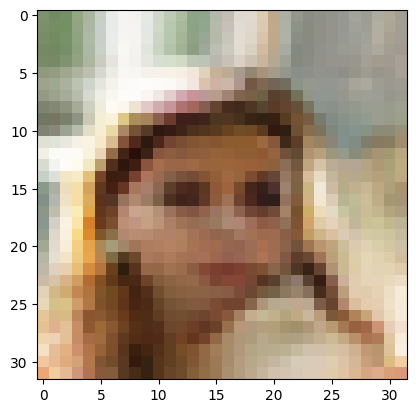

Epoch: 20 Step: 0, discriminant loss: 1.1706018447875977
Epoch: 20, Step: 0, generator loss: 0.9556887745857239
Epoch: 20 Step: 250, discriminant loss: 0.9476111531257629
Epoch: 20, Step: 250, generator loss: 1.1146235466003418
Epoch: 20 Step: 500, discriminant loss: 1.0181598663330078
Epoch: 20, Step: 500, generator loss: 1.1489589214324951
Epoch: 20 Step: 750, discriminant loss: 0.931733250617981
Epoch: 20, Step: 750, generator loss: 1.3452541828155518
Epoch: 20 Step: 1000, discriminant loss: 1.0588023662567139
Epoch: 20, Step: 1000, generator loss: 1.1168283224105835
Epoch: 20 Step: 1250, discriminant loss: 1.1766338348388672
Epoch: 20, Step: 1250, generator loss: 0.8530948162078857
Epoch: 20 Step: 1500, discriminant loss: 1.2384672164916992
Epoch: 20, Step: 1500, generator loss: 1.2260452508926392
Epoch: 20 Step: 1750, discriminant loss: 1.000766396522522
Epoch: 20, Step: 1750, generator loss: 1.1684633493423462
Epoch: 20 Step: 2000, discriminant loss: 1.0020699501037598
Epoch: 20,

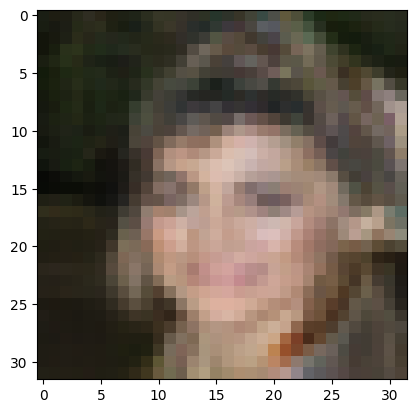

Epoch: 21 Step: 0, discriminant loss: 1.0548975467681885
Epoch: 21, Step: 0, generator loss: 1.1546508073806763
Epoch: 21 Step: 250, discriminant loss: 0.9403485059738159
Epoch: 21, Step: 250, generator loss: 1.59557044506073


KeyboardInterrupt: 

In [23]:
from tqdm.auto import tqdm

epochs = 50
batch_size = 64
noise_len = 100
k = 1

real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

loss_fn = nn.BCELoss()

generator = DCGenerator().to(device)
discriminator = DCDiscriminator().to(device)

gen_optimizer = torch.optim.Adam(generator.parameters(),
                                 lr = 0.0002,
                                 betas = (0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(),
                                 lr = 0.0002,
                                 betas = (0.5, 0.999))

for epoch in tqdm(range(epochs)):

    for ind, (X, _) in enumerate(train_dataloader):

        discriminator.train()
        generator.train()

        X = X.to(device)
        # Take disc loss with real images
        disc_output = discriminator(X)
        disc_real_loss = loss_fn(disc_output, real_labels)

        # Generate fake images and take disc loss
        noise = torch.randn(batch_size, noise_len).to(device)
        disc_output = discriminator(generator(noise))

        disc_fake_loss = loss_fn(disc_output, fake_labels)

        disc_loss = disc_real_loss + disc_fake_loss

        if ind % 250 == 0:
            print(f"Epoch: {epoch} Step: {ind}, discriminant loss: {disc_loss}")

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        if ind % k == 0:
            noise = torch.randn(batch_size, noise_len).to(device)
            disc_output = discriminator(generator(noise))
            gen_loss = loss_fn(disc_output, real_labels)

            if ind % 250 == 0:
                print(f"Epoch: {epoch}, Step: {ind}, generator loss: {gen_loss}")

            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

    generator.eval()
    gen_image = generator(torch.randn(1, 100).to(device)).cpu().detach().squeeze().permute(1,2,0)
    plt.imshow((gen_image + 1) / 2, cmap="gray")
    plt.show()

Ran out of Colab GPU time but the model is on the right path and training can easily continue by loading the saved generator and discriminator

In [ ]:
!mkdir models
!mkdir models/celeba

In [25]:
from pathlib import Path

model_path = Path("models")

torch.save(generator, model_path / "celeba" / "generator_cifar.pth")
torch.save(discriminator, model_path / "celeba" / "discriminator_cifar.pth")

In [28]:
!zip -r celeba_dcgan.zip /content/models

updating: content/models/ (stored 0%)
updating: content/models/celeba/ (stored 0%)
updating: content/models/celeba/discriminator_cifar.pth (deflated 8%)
updating: content/models/celeba/generator_cifar.pth (deflated 7%)
updating: content/models/.ipynb_checkpoints/ (stored 0%)


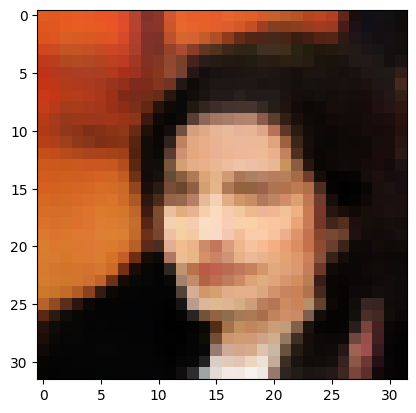

In [49]:
generator.eval()
gen_image = generator(torch.randn(1, 100).to(device)).cpu().detach().squeeze().permute(1,2,0)
plt.imshow((gen_image + 1) / 2, cmap="gray")
plt.show()